<a href="https://colab.research.google.com/github/nahyeon-an/python/blob/main/ML/time-series/water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 문제  
팔당댐 방류 -> 주요 다리 수위 예측  

In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

## submission 예시

In [5]:
base_path = "drive/MyDrive/waterfall/competition_data"

In [6]:
submit = pd.read_csv(base_path + '/sample_submission.csv')

In [7]:
submit.head()

ymdhm  wl_1018662  wl_1018680  wl_1018683  wl_1019630
0  2022-06-01 00:00           0           0           0           0
1  2022-06-01 00:10           0           0           0           0
2  2022-06-01 00:20           0           0           0           0
3  2022-06-01 00:30           0           0           0           0
4  2022-06-01 00:40           0           0           0           0

## Data Load

### water  

In [7]:
water_data = []
for year in range(2012, 2023):
    water_data.append(
        pd.read_csv(f"{base_path}/water_data/data_{year}.csv",
                    parse_dates=['ymdhm'])
    )

water_df = pd.concat(water_data, axis=0)
water_df = water_df.set_index('ymdhm')

In [9]:
water_df.head()

swl    inf     sfw   ecpc  tototf  tide_level  \
ymdhm                                                                   
2012-05-01 00:00:00  24.800  555.0  219.07  24.93   555.0       445.0   
2012-05-01 00:10:00  24.794  464.6  218.86  25.15   562.9       449.0   
2012-05-01 00:20:00  24.789  478.1  218.69  25.31   576.4       451.0   
2012-05-01 00:30:00  24.789  464.8  218.69  25.31   563.1       452.0   
2012-05-01 00:40:00  24.789  478.1  218.69  25.31   576.4       450.0   

                     wl_1018662  fw_1018662  wl_1018680  fw_1018680  \
ymdhm                                                                 
2012-05-01 00:00:00       310.7      469.05       300.2         0.0   
2012-05-01 00:10:00       314.7      498.00       300.2         0.0   
2012-05-01 00:20:00       313.7      490.68       301.2         0.0   
2012-05-01 00:30:00       311.7      476.21       301.2         0.0   
2012-05-01 00:40:00       311.7      476.21       301.2         0.0   

                     wl_1018683  fw_1018683  wl_1019630  fw_1019630  
ymdhm                                                                
2012-05-01 00:00:00       290.0      729.80       275.3      540.18  
2012-05-01 00:10:00       290.0      731.48       275.3      540.18  
2012-05-01 00:20:00       290.0      726.42       275.3      540.18  
2012-05-01 00:30:00       290.0      726.42       276.3      552.17  
2012-05-01 00:40:00       291.0      707.17       277.3      564.29

In [45]:
target_cols = ['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']

## Waterfall data

### swl : 팔당댐 현재 수위

Text(0.5, 1.0, 'swl')

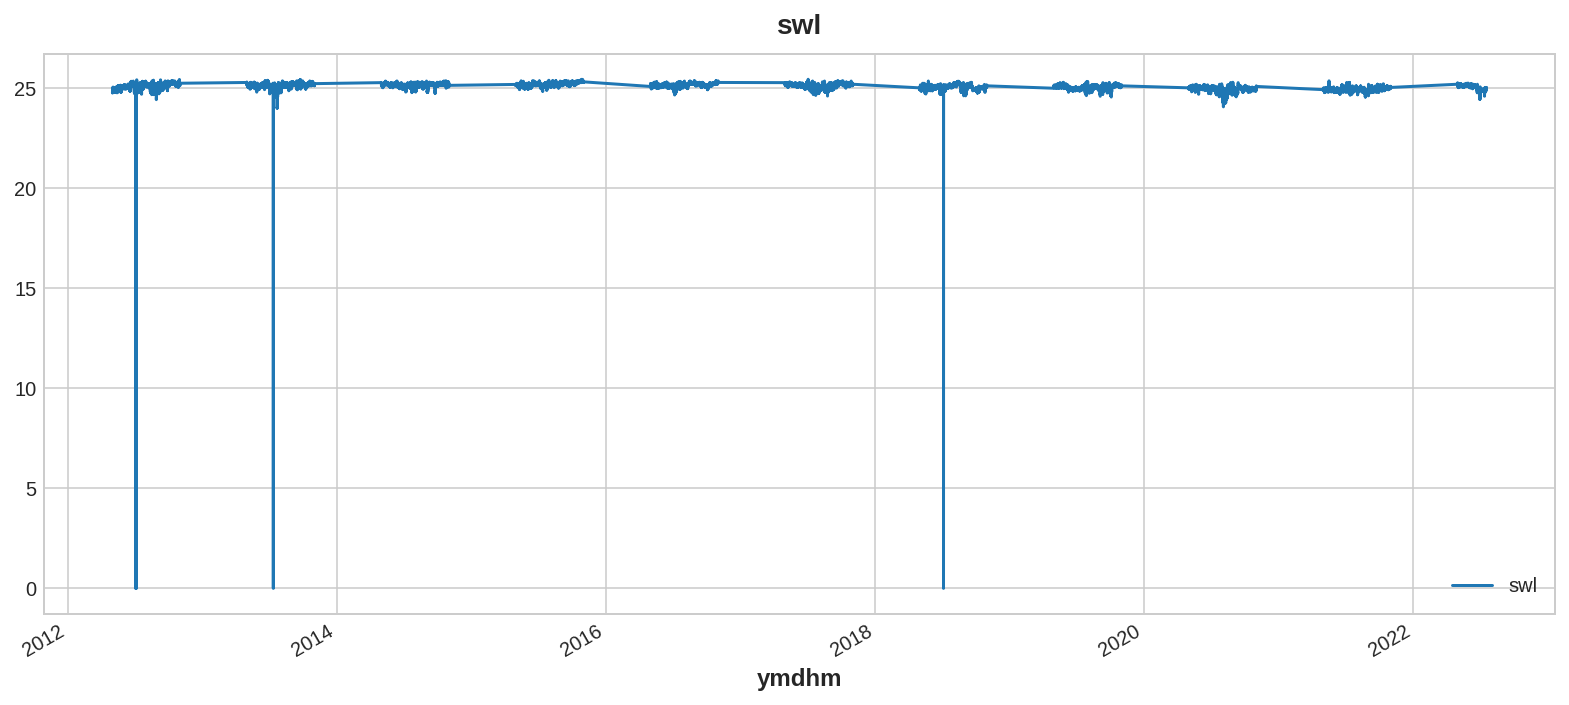

In [10]:
swl_df = water_df.loc[:, 'swl'].to_frame()
ax = swl_df.plot()
ax.set_title("swl")

In [11]:
swl_df.dropna()

swl
ymdhm                      
2012-05-01 00:00:00  24.800
2012-05-01 00:10:00  24.794
2012-05-01 00:20:00  24.789
2012-05-01 00:30:00  24.789
2012-05-01 00:40:00  24.789
...                     ...
2022-07-18 23:10:00  25.040
2022-07-18 23:20:00  25.040
2022-07-18 23:30:00  25.040
2022-07-18 23:40:00  25.040
2022-07-18 23:50:00  25.040

[275593 rows x 1 columns]

In [12]:
swl_df.head()

swl
ymdhm                      
2012-05-01 00:00:00  24.800
2012-05-01 00:10:00  24.794
2012-05-01 00:20:00  24.789
2012-05-01 00:30:00  24.789
2012-05-01 00:40:00  24.789

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


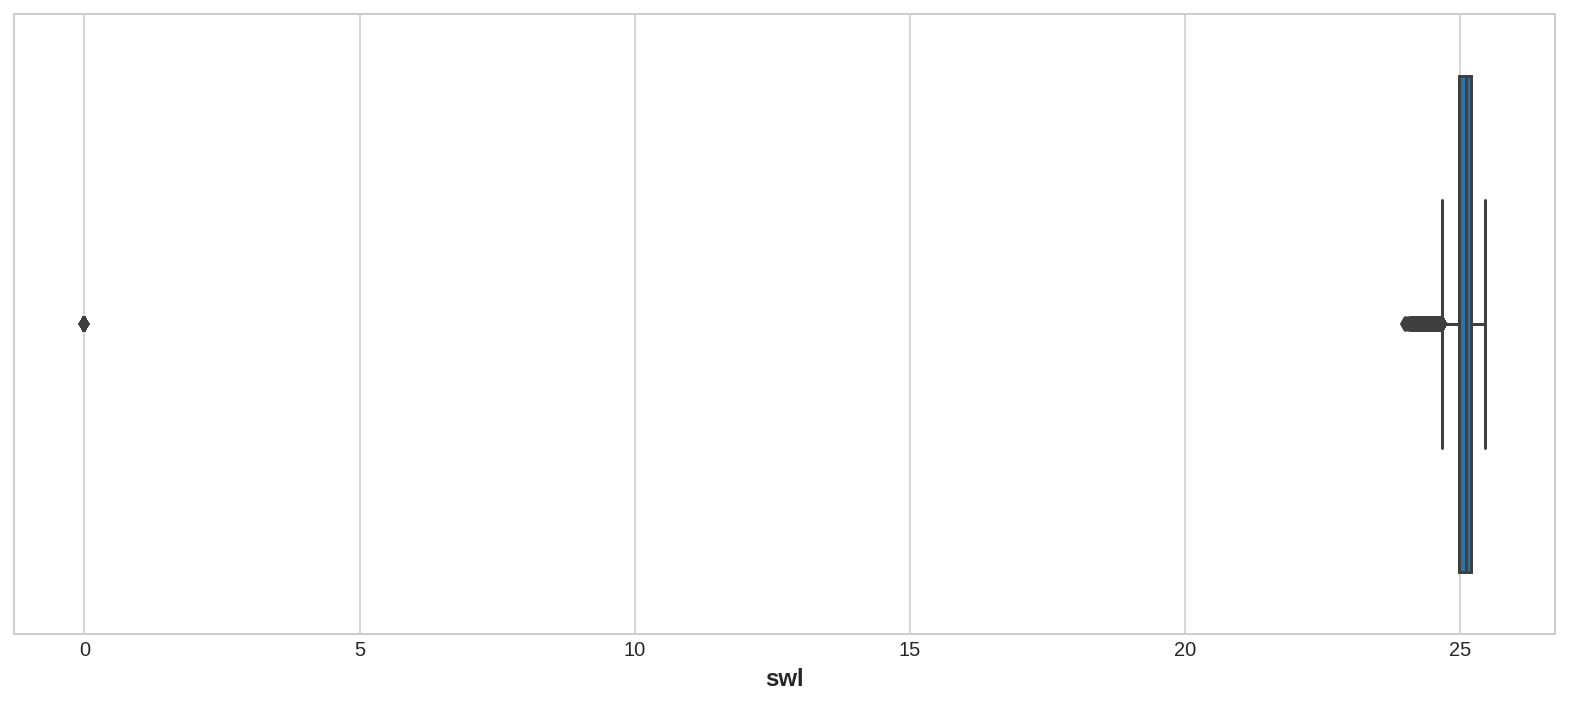

In [13]:
sns.boxplot(swl_df['swl'])

In [16]:
swl_df.describe()

swl
count  275593.000000
mean       25.071738
std         0.459075
min         0.000000
25%        24.980000
50%        25.100000
75%        25.190000
max        25.449000

#### iqr outlier 제거

In [14]:
q1 = swl_df.quantile(0.25)
q3 = swl_df.quantile(0.75)
iqr = q3 - q1

In [15]:
swl_df = swl_df[swl_df > q1 - 1.5 * iqr]

Text(0.5, 1.0, 'swl : remove outliers')

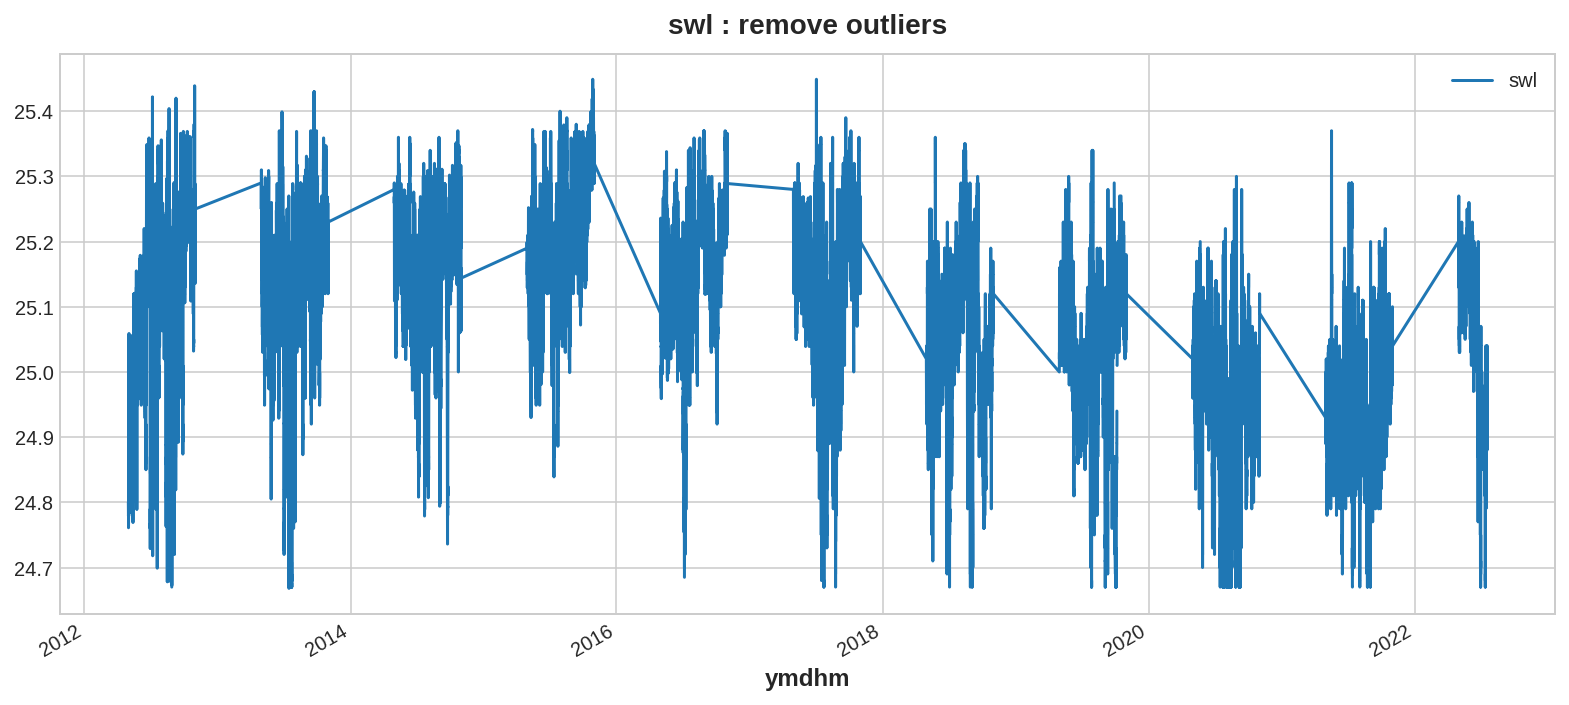

In [16]:
ax = swl_df.plot()
ax.set_title("swl : remove outliers")

In [20]:
swl_df.describe()

swl
count  273241.000000
mean       25.083645
std         0.138485
min        24.668000
25%        24.980000
50%        25.108000
75%        25.190000
max        25.449000

#### yearly seasonality plot 

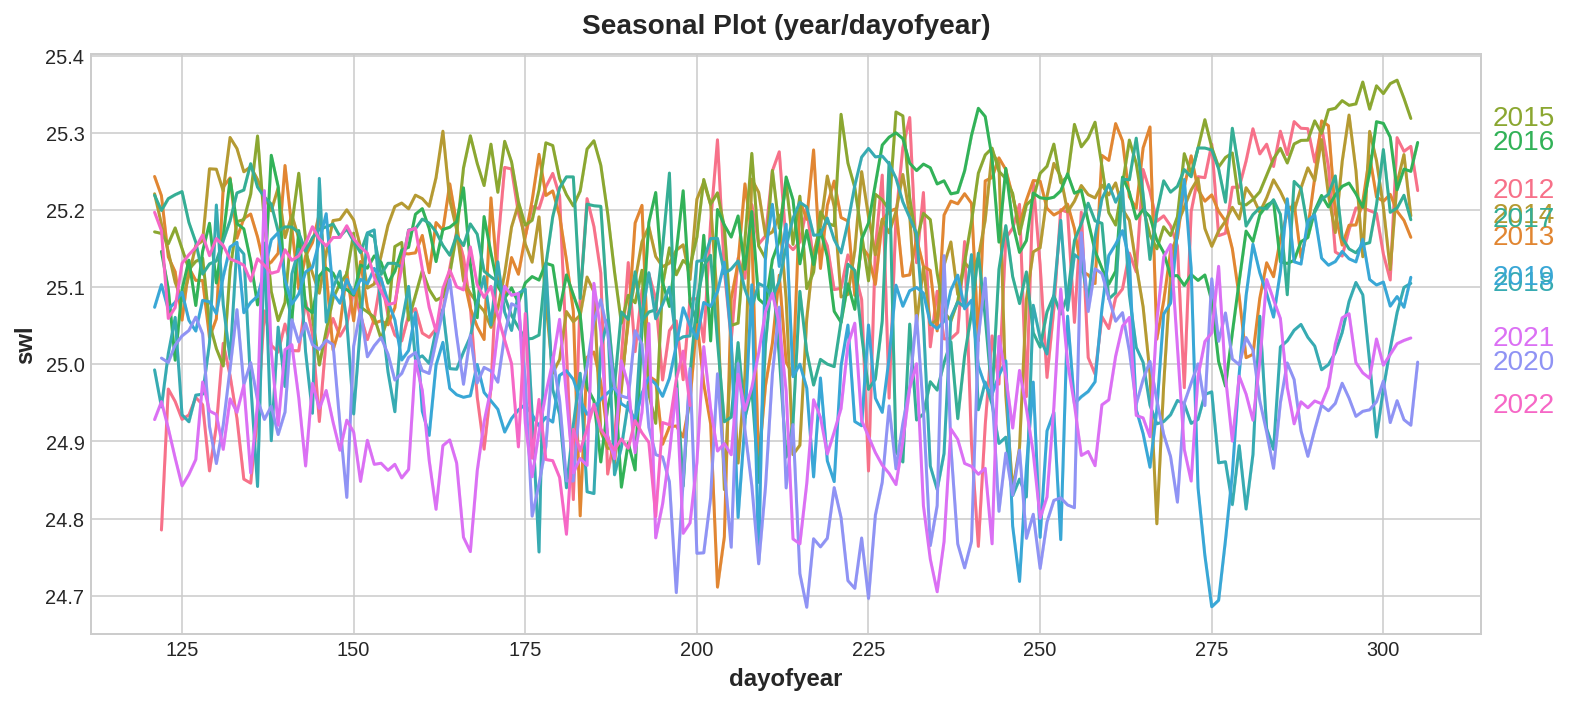

In [21]:
X = swl_df.copy()
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear
seasonal_plot(X, y='swl', period='year', freq='dayofyear')

#### periodogram

semi annual (여름에 계절성 보임)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


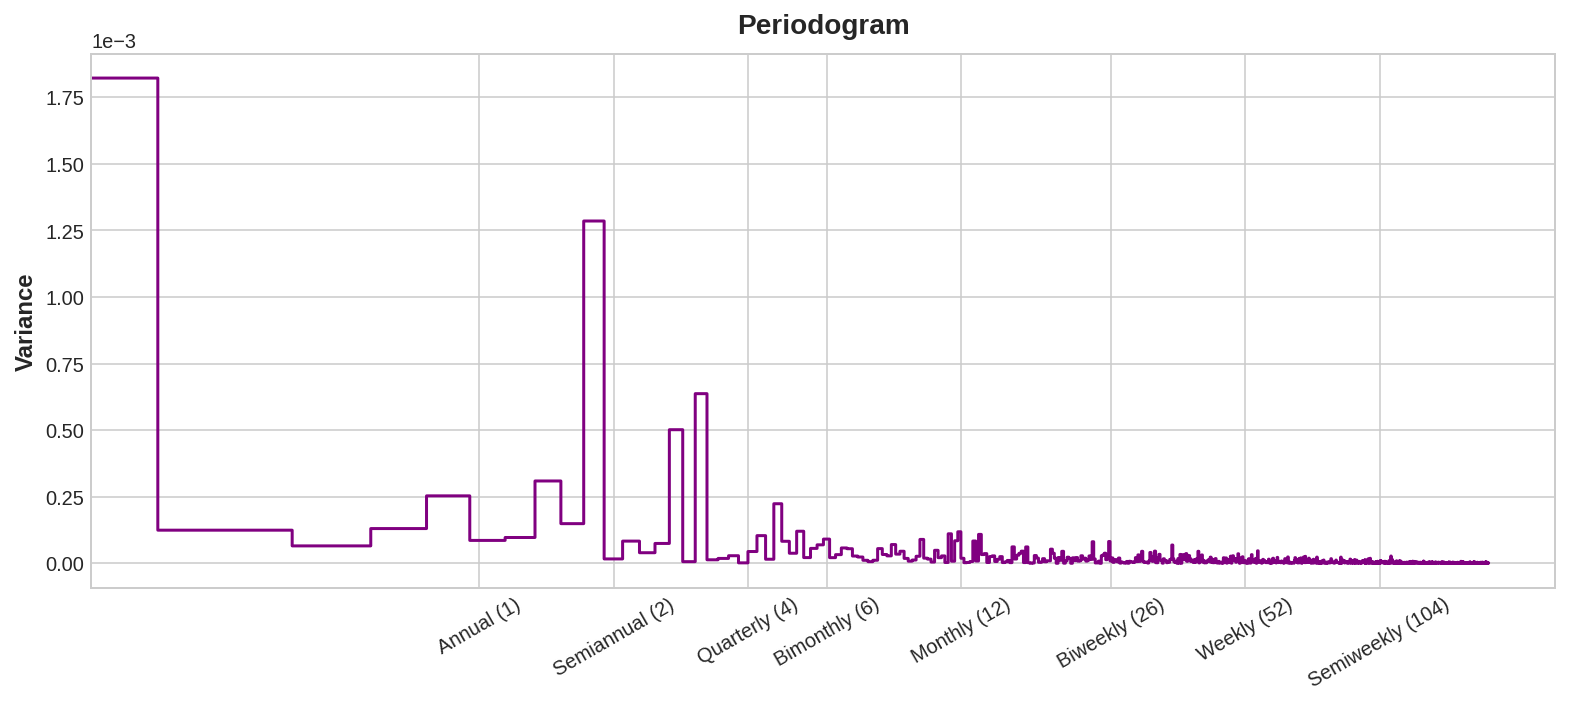

In [17]:
swl_df = swl_df[swl_df != np.nan].dropna()
average_df = swl_df.to_period('D').groupby('ymdhm').mean()
plot_periodogram(average_df.swl)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipyker

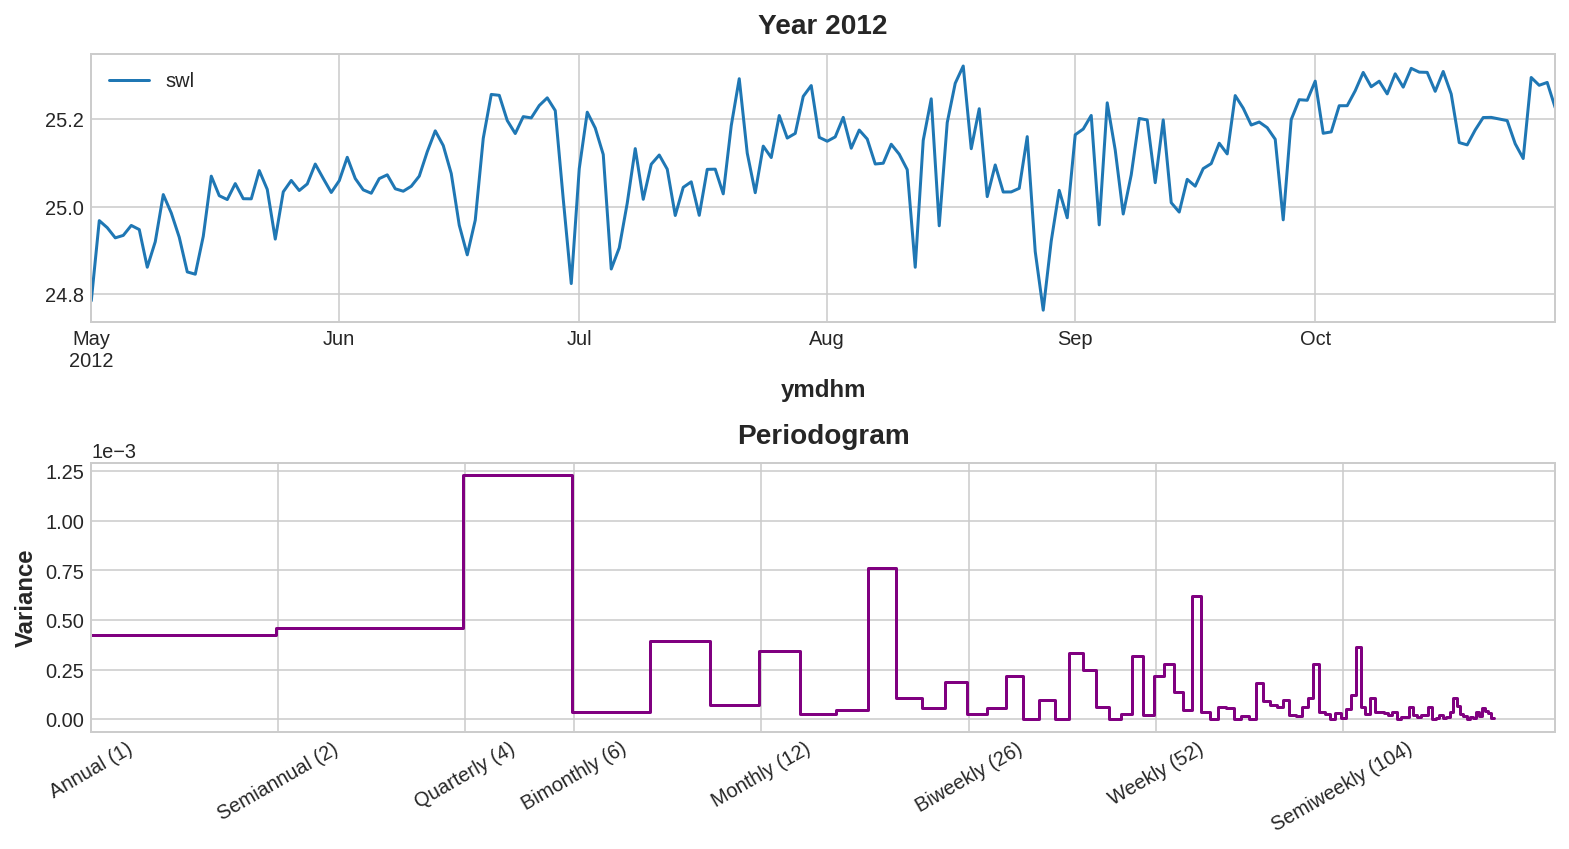

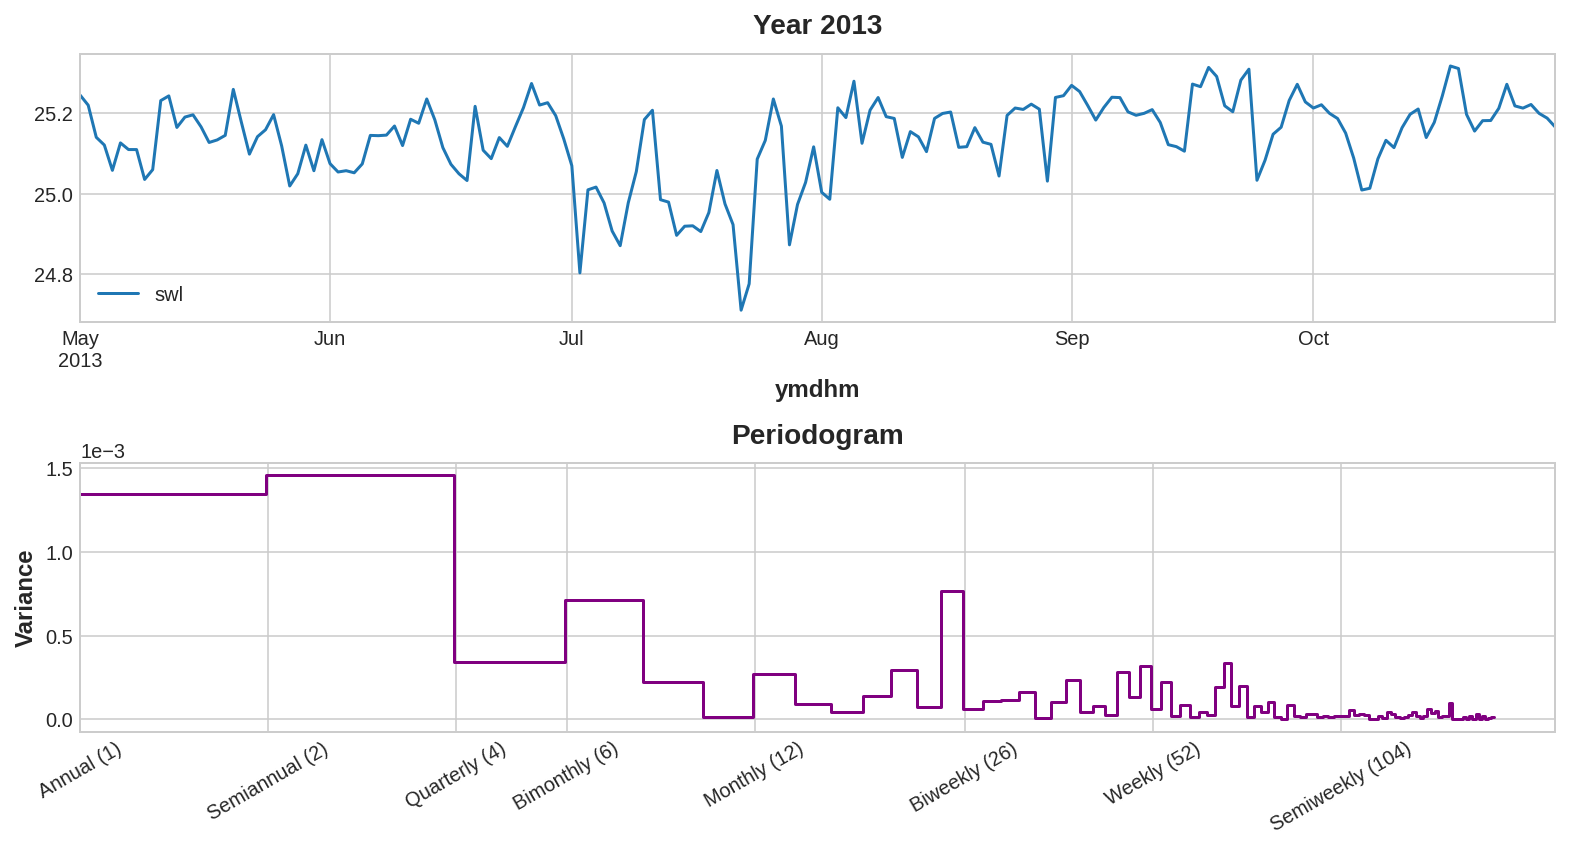

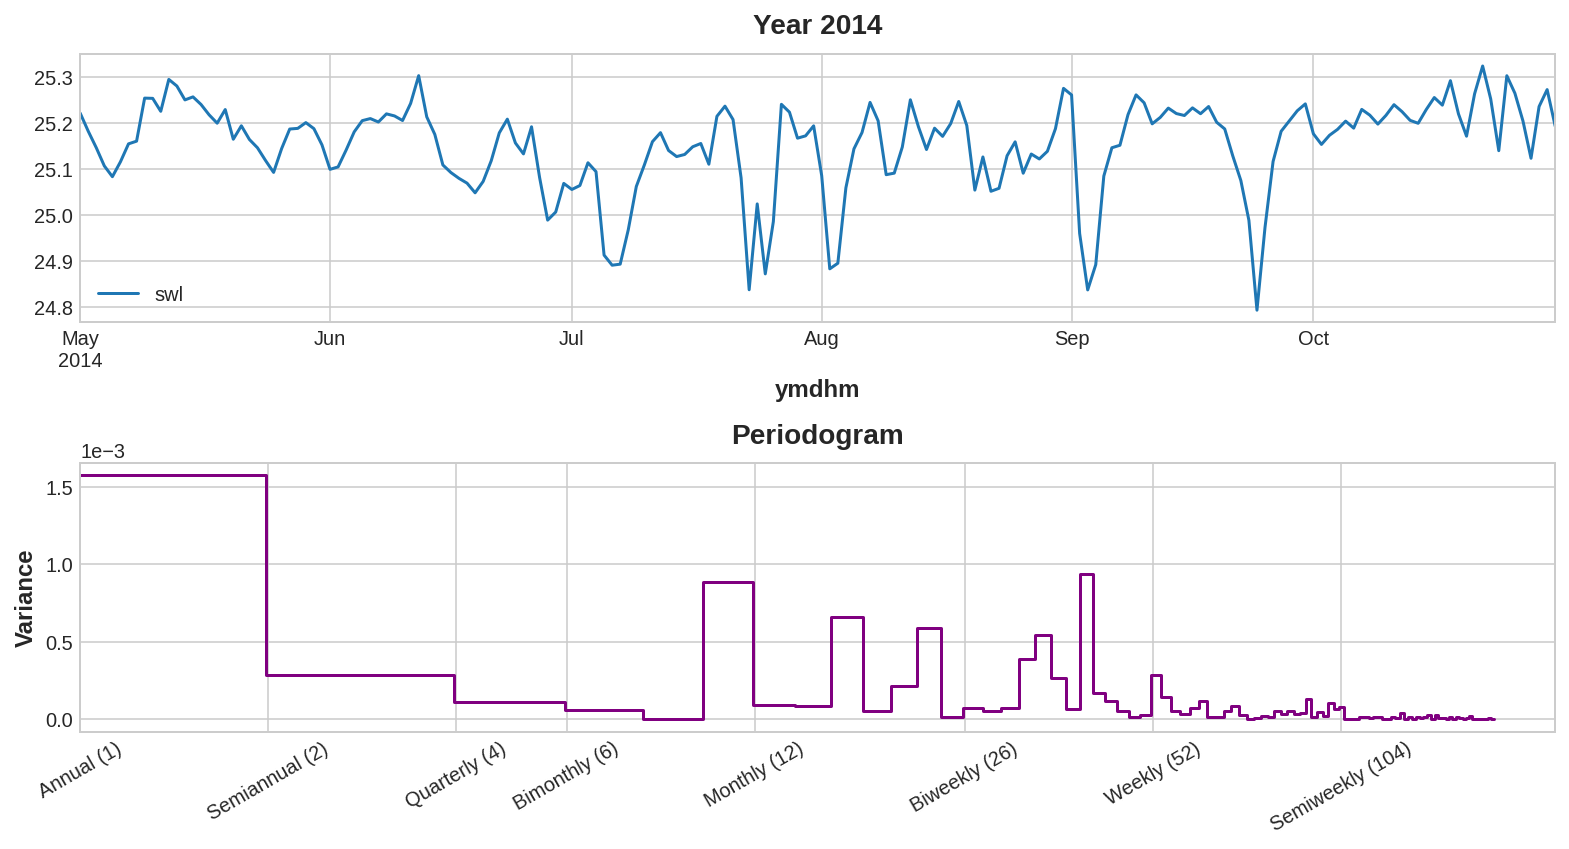

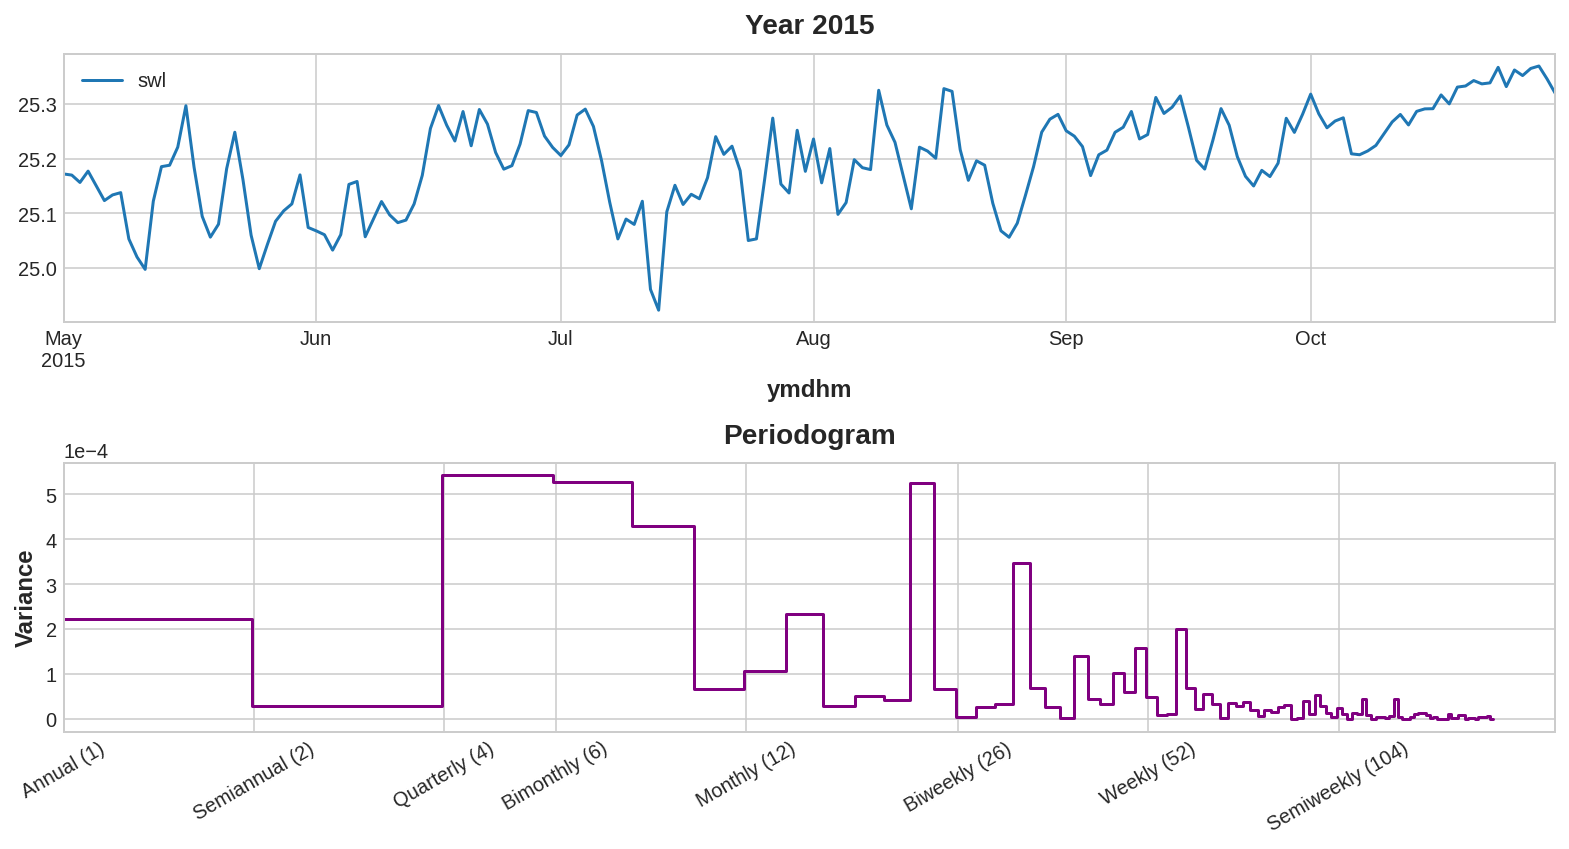

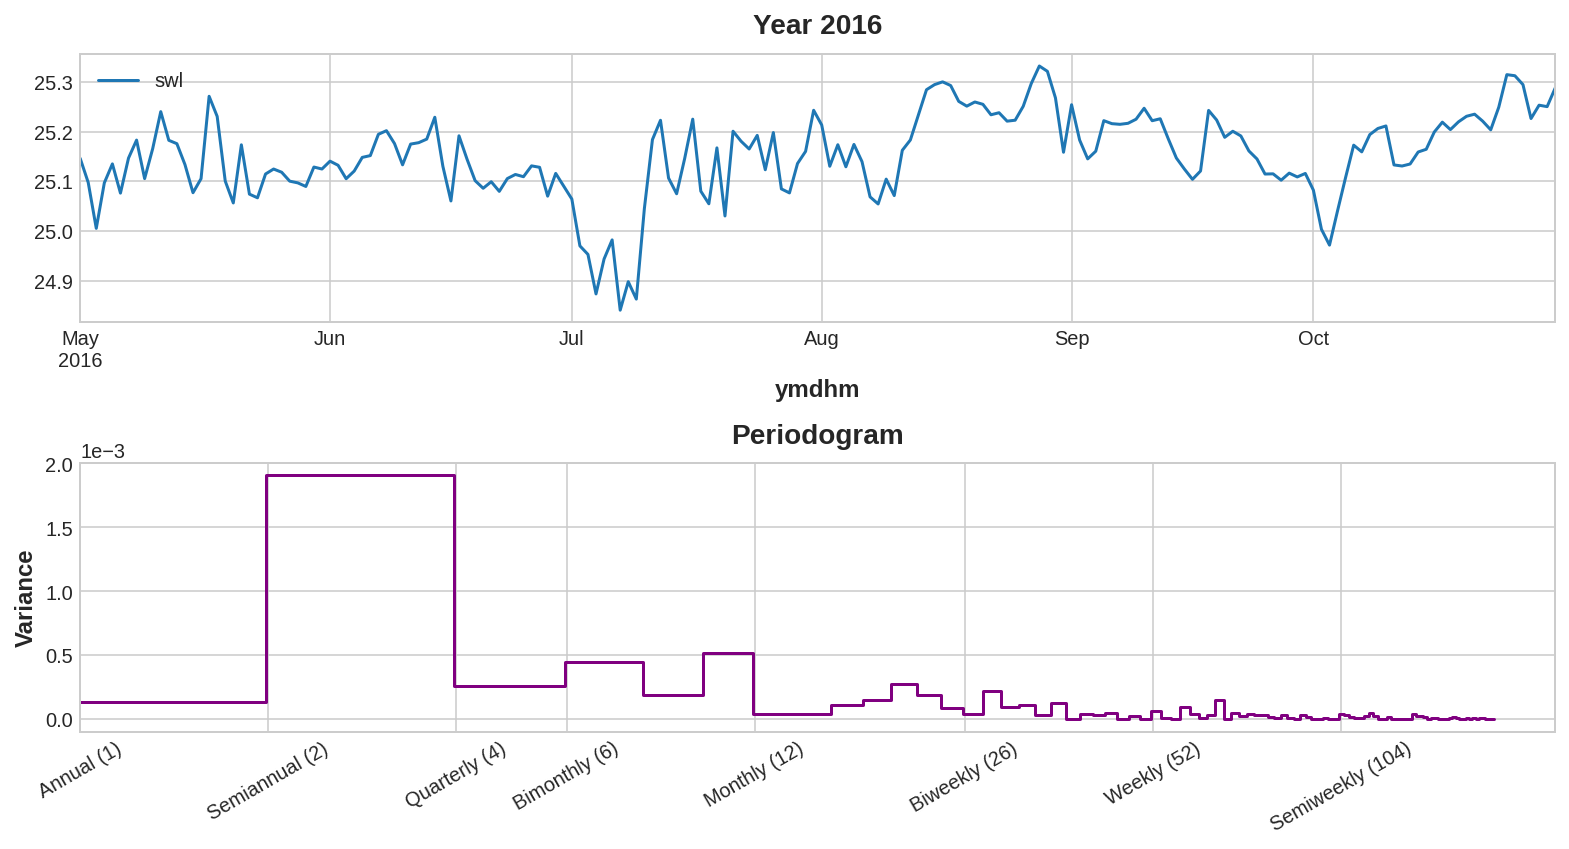

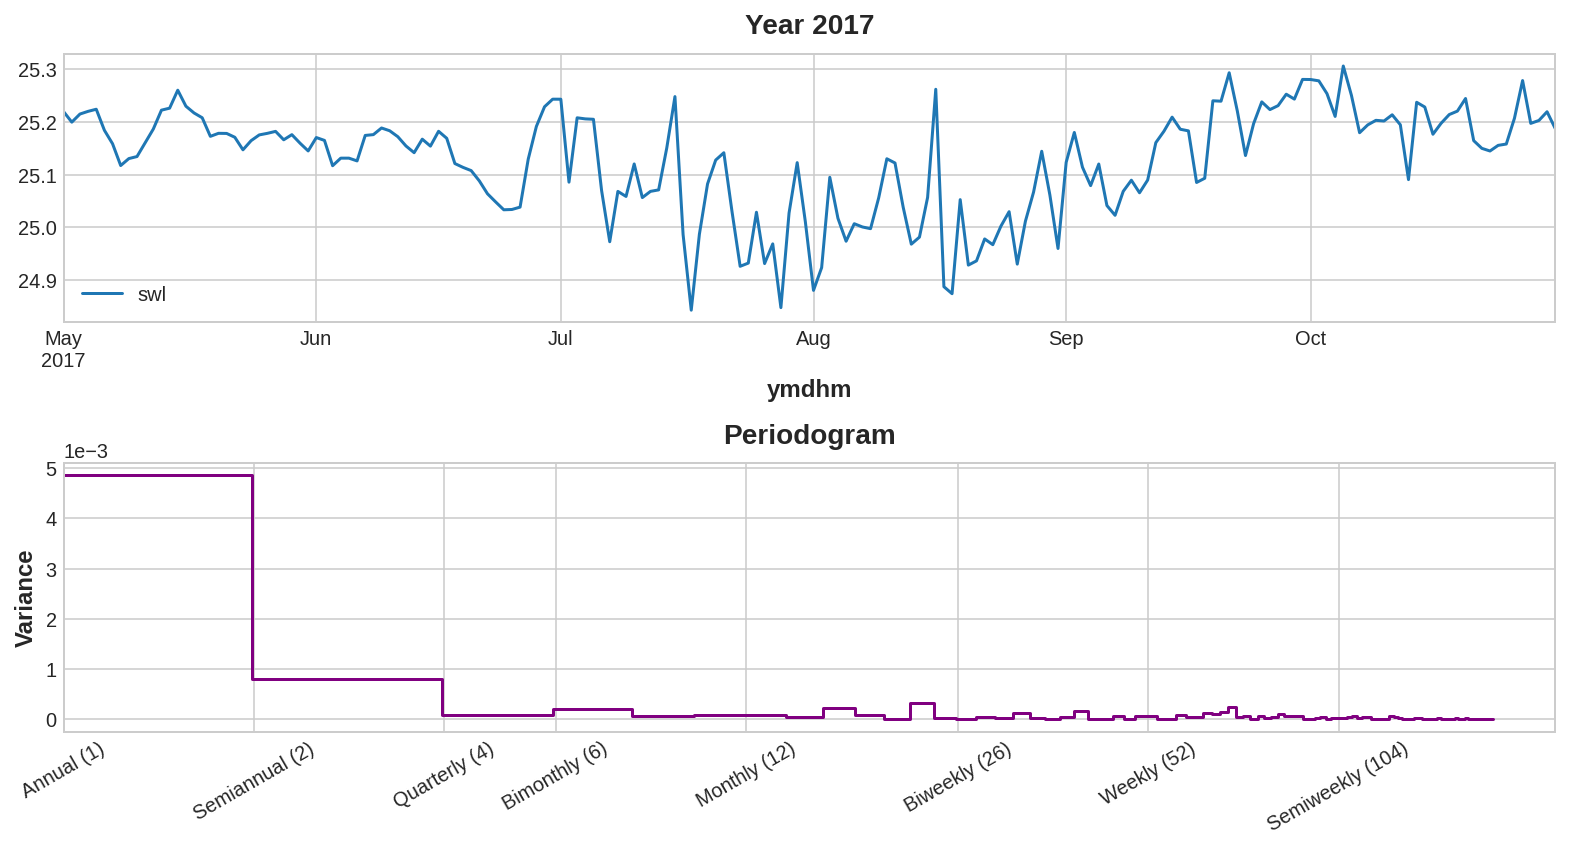

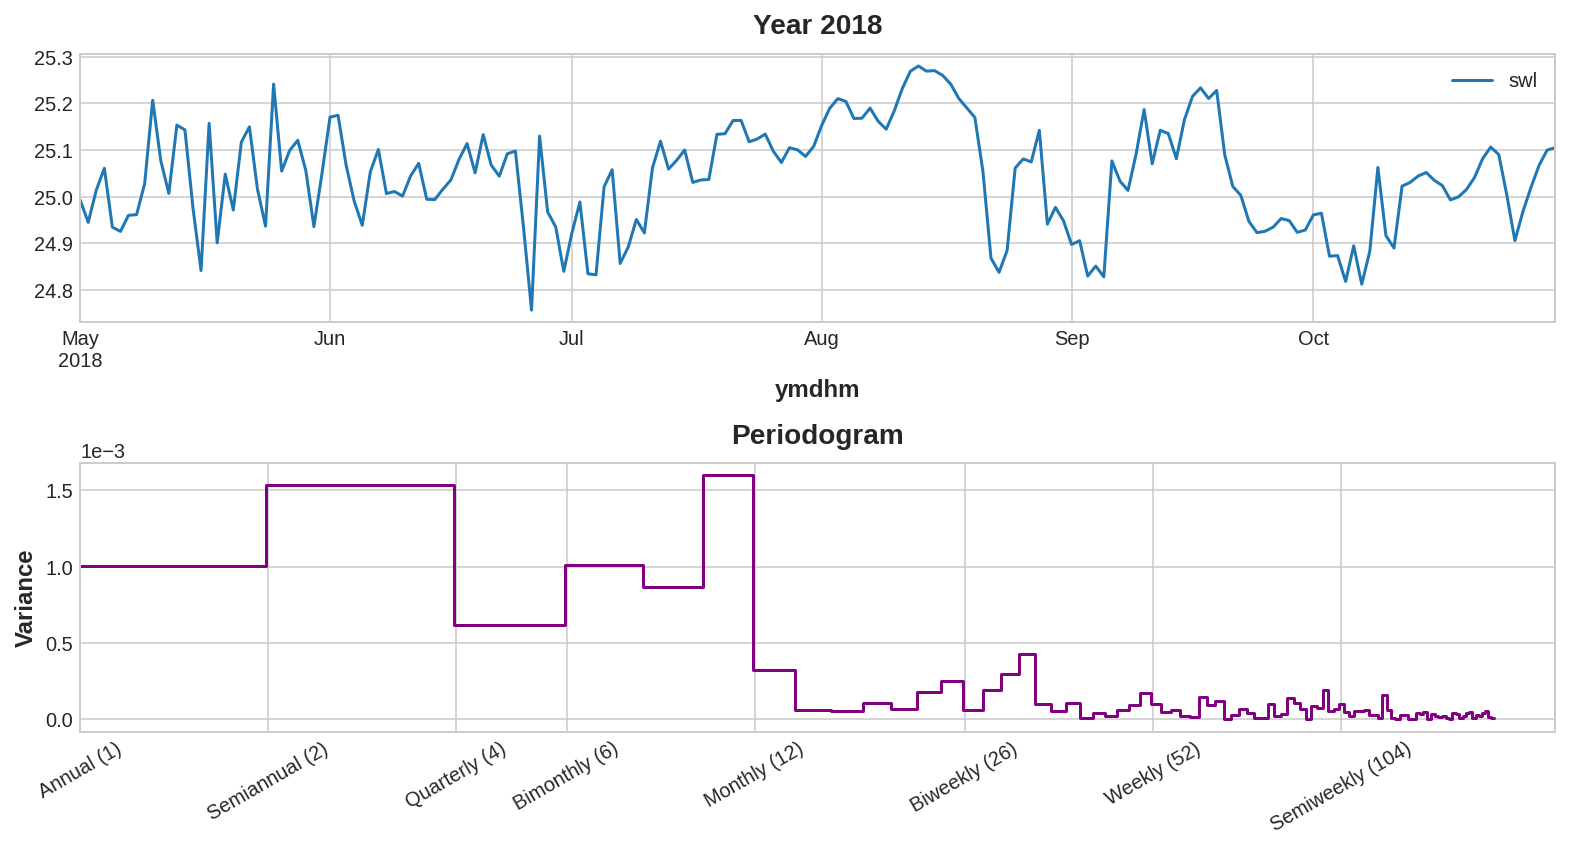

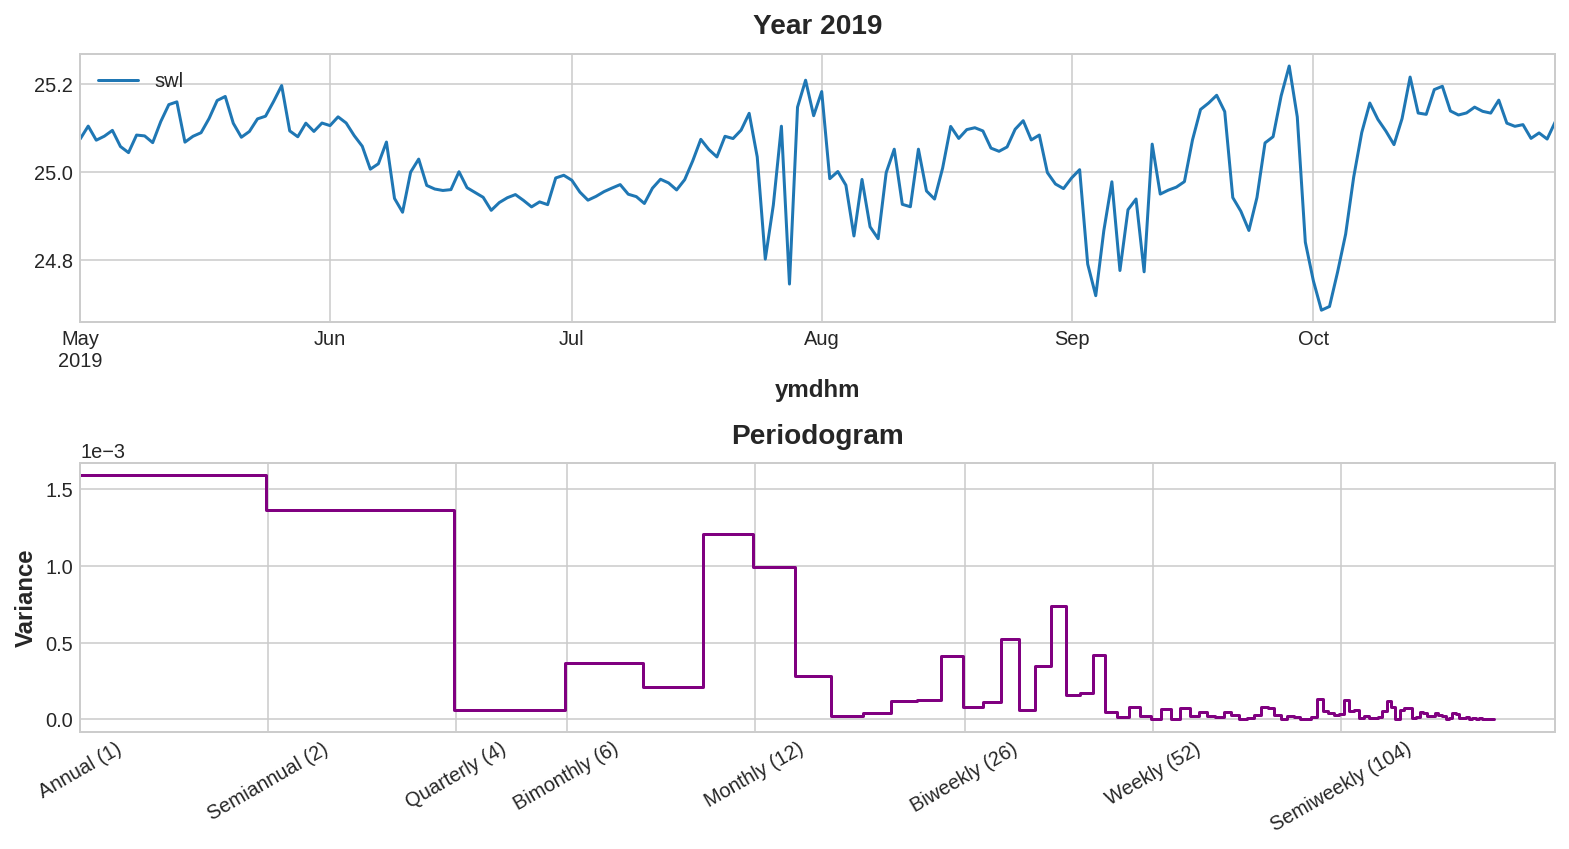

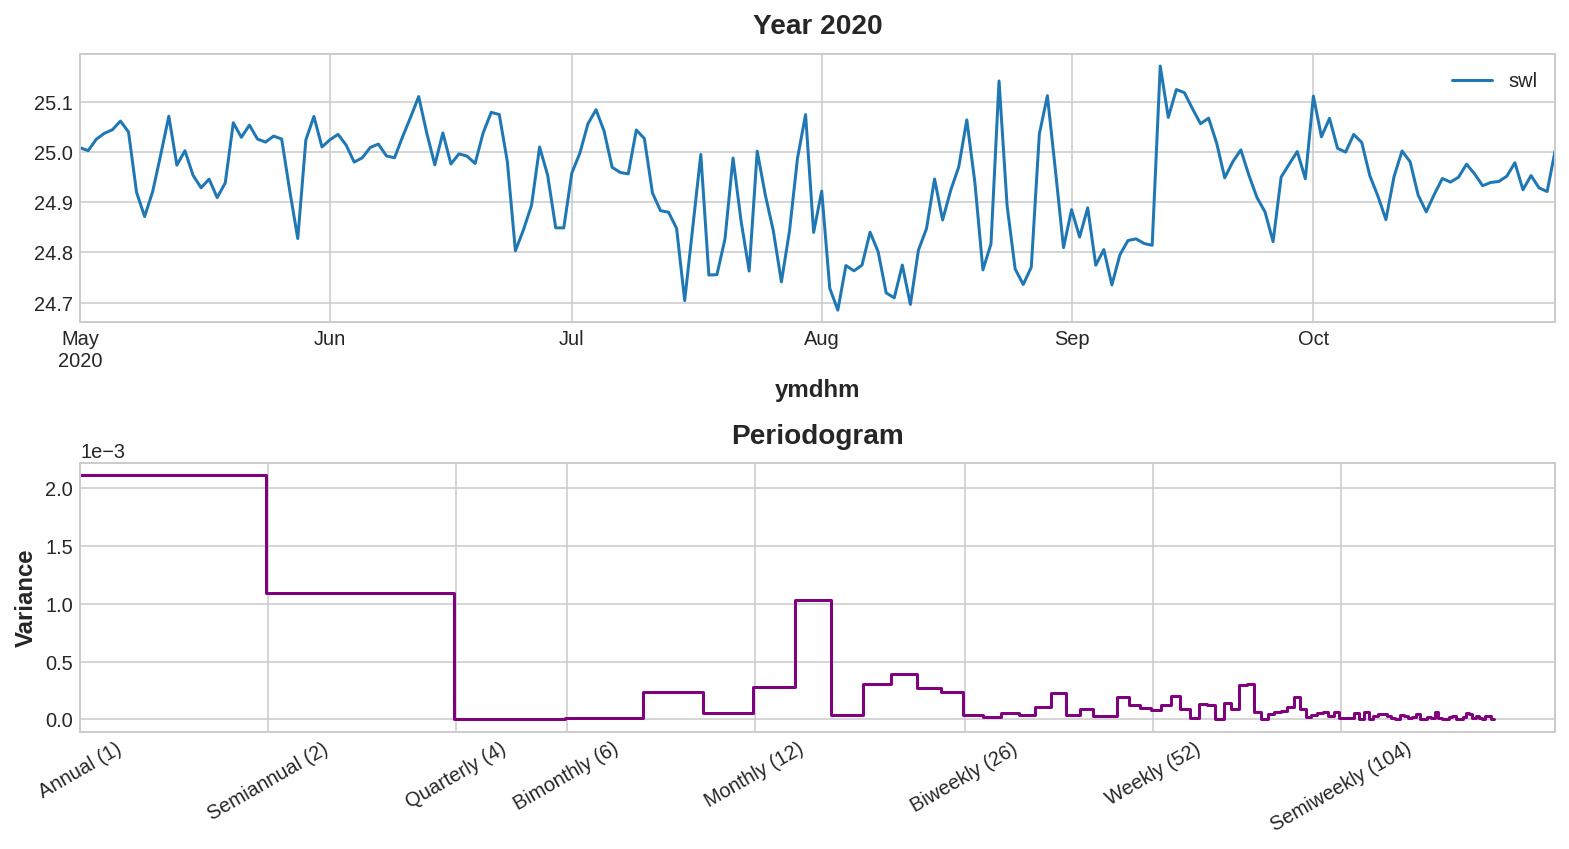

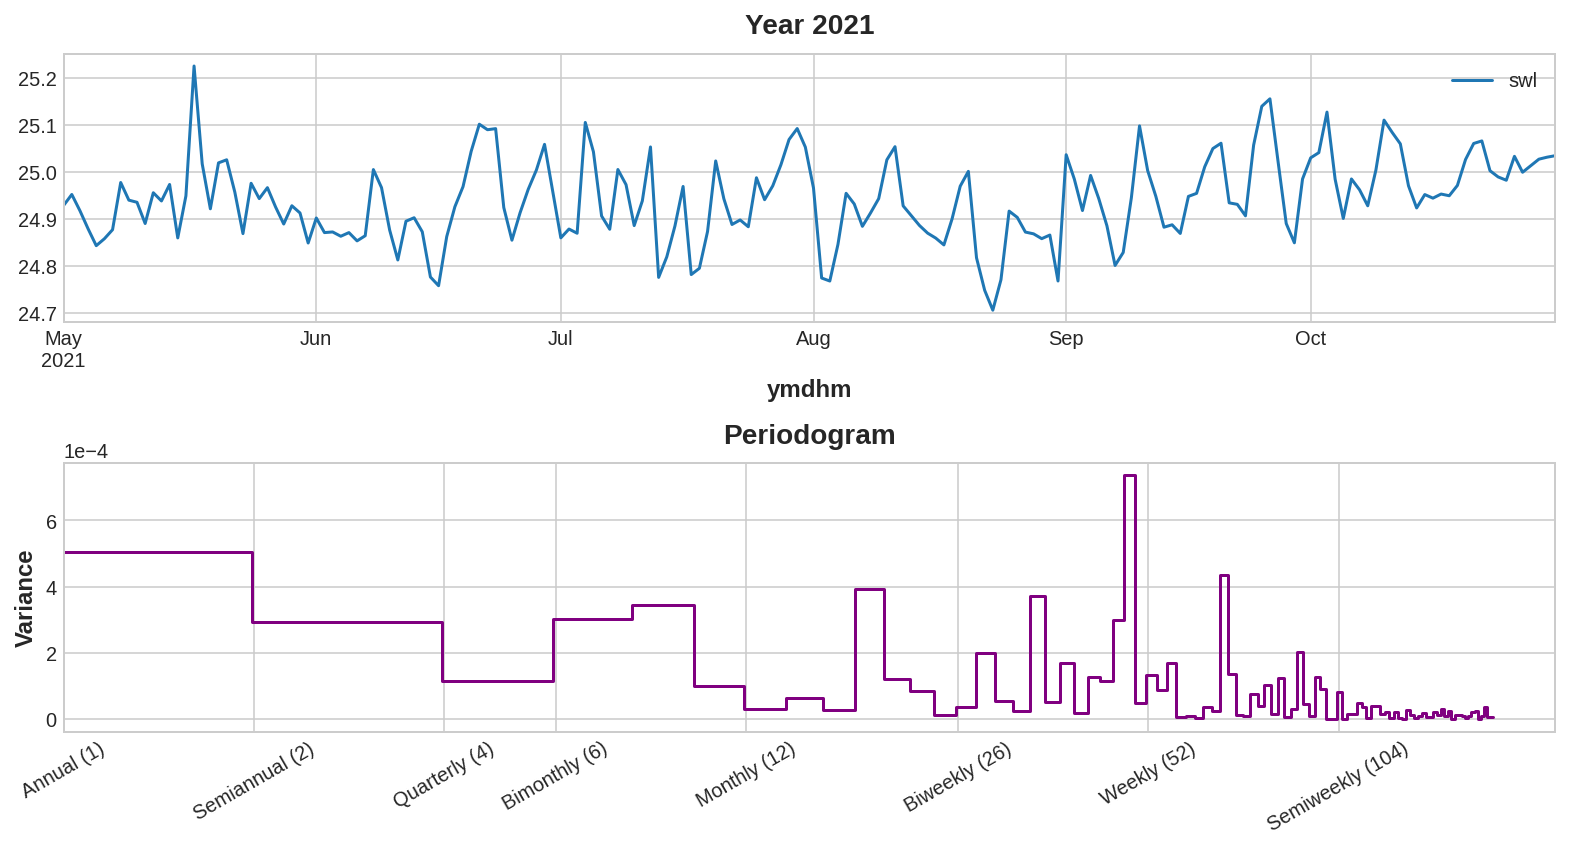

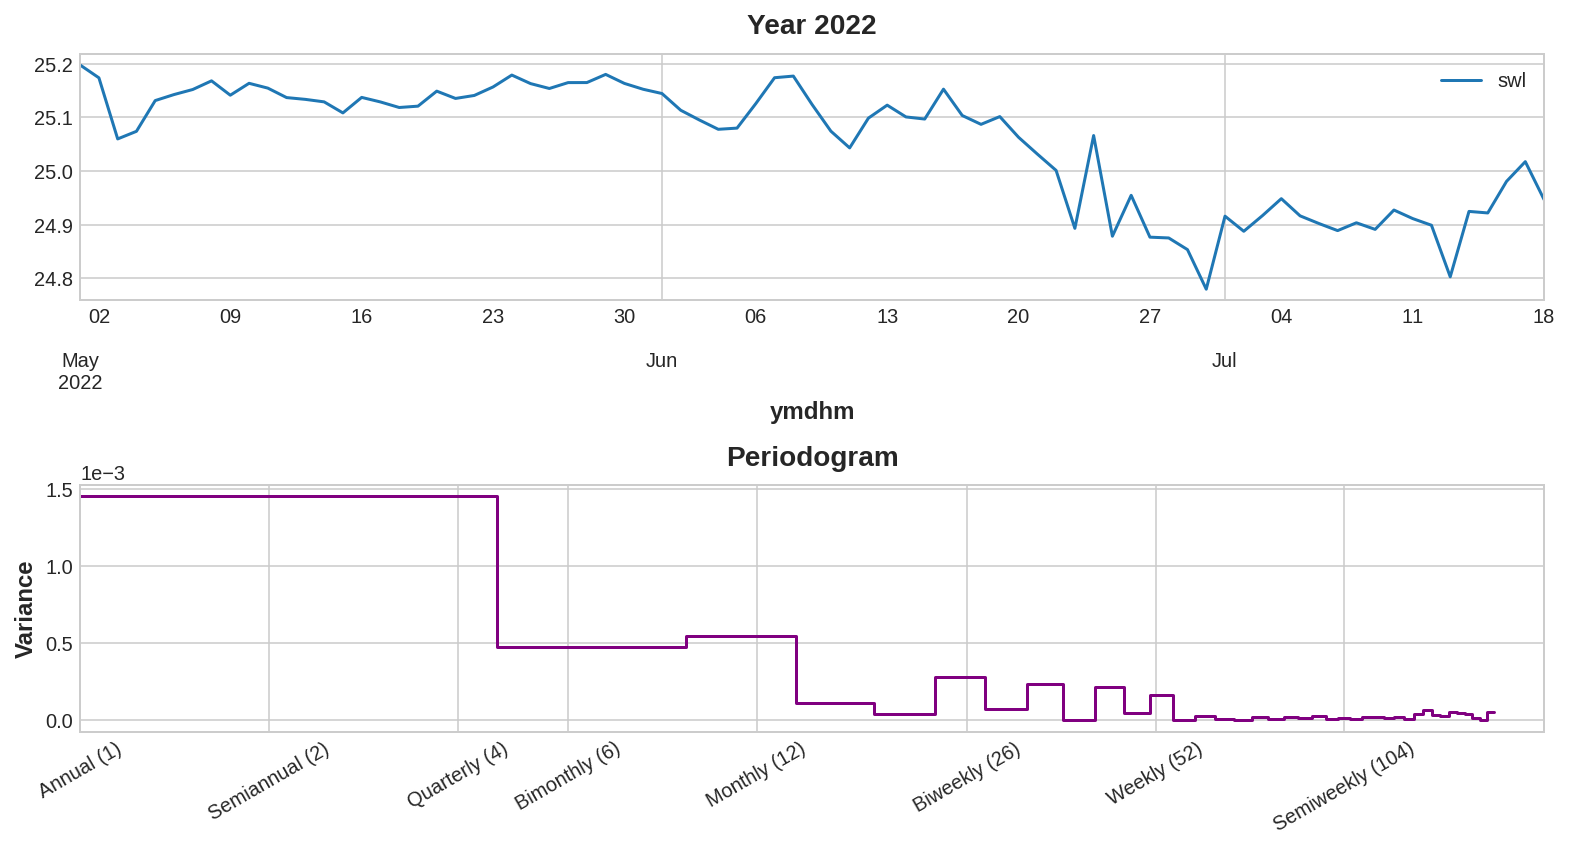

In [66]:
for i in range(0, 11):
    year = 2012 + i
    yearly_df = swl_df[swl_df.index.year == year].to_period("D")
    average_df = yearly_df.groupby('ymdhm').mean()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
    average_df.plot(ax=ax1)
    ax1.set_title(f'Year {year}')
    plot_periodogram(average_df.swl, ax=ax2)

### tototf : 총 방류량

Text(0.5, 1.0, 'tototf')

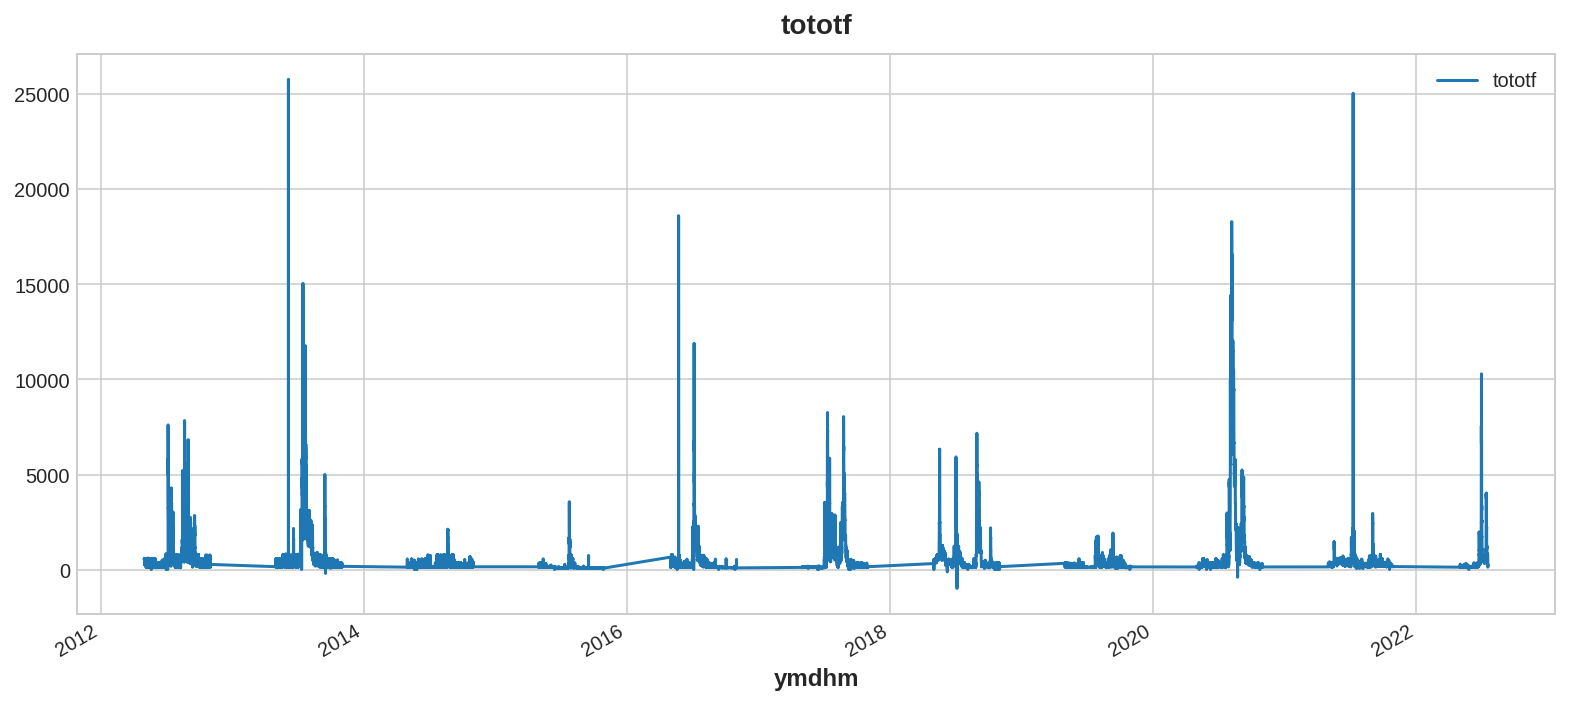

In [8]:
tot_df = water_df.loc[:, 'tototf'].to_frame()
ax = tot_df.plot()
ax.set_title("tototf")

In [19]:
tot_df.describe()

tototf
count  275593.000000
mean      542.751685
std      1105.604956
min      -990.000000
25%       132.000000
50%       175.000000
75%       507.000000
max     25791.500000

In [9]:
tot_df = tot_df[tot_df['tototf'] > 0].dropna()

Text(0.5, 1.0, 'tototf')

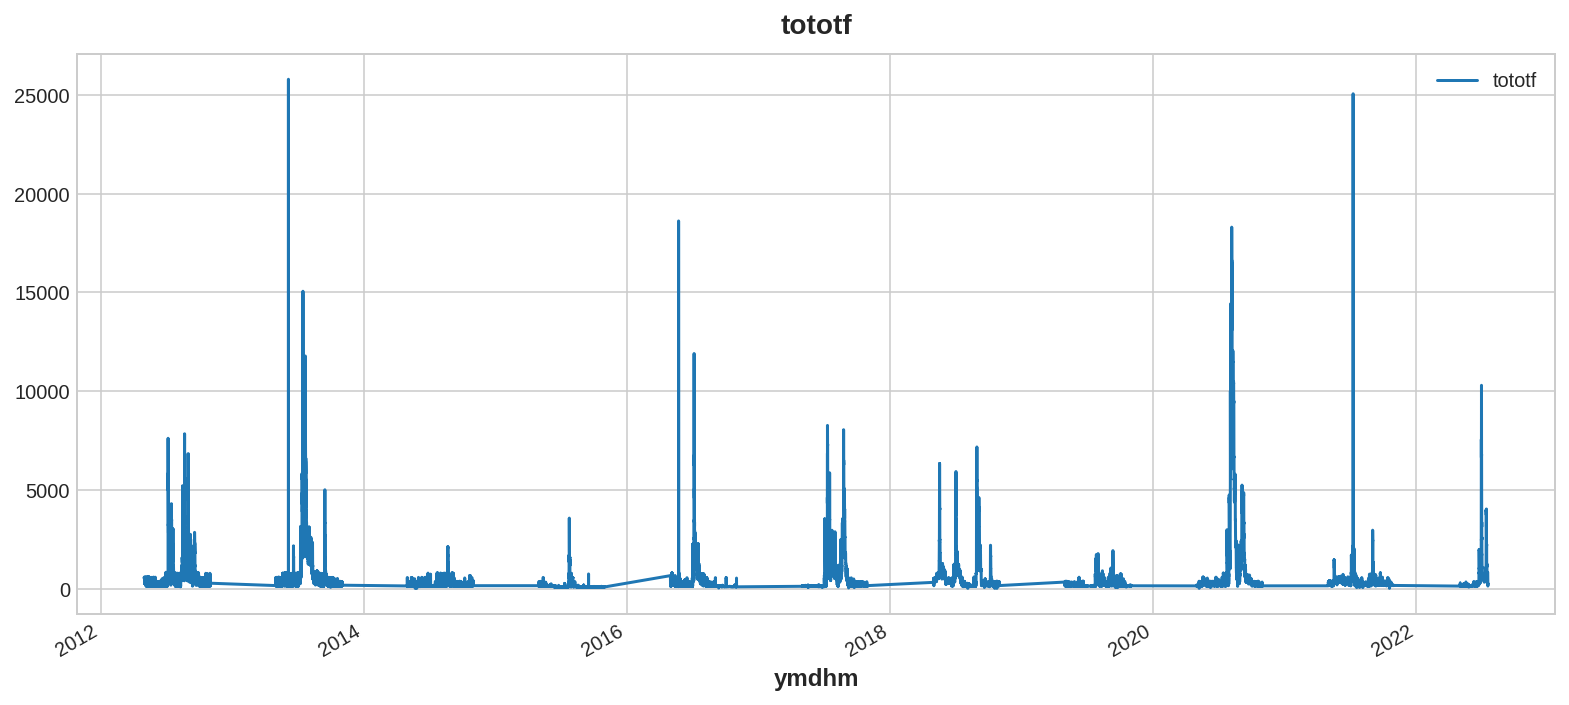

In [21]:
ax = tot_df.plot()
ax.set_title("tototf")

#### 일별 periodogram

2 ~ 3개월의 계절성 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


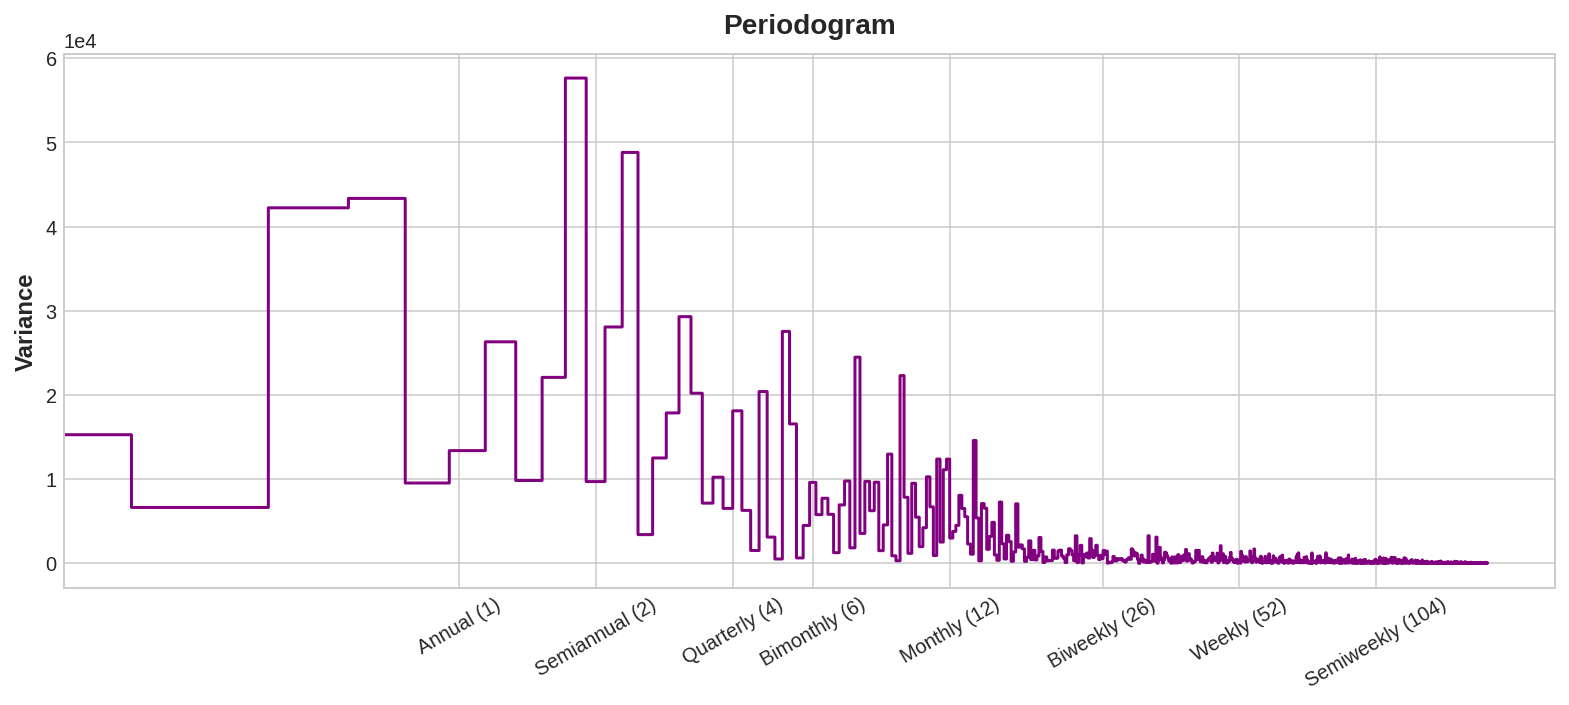

In [22]:
average_df = tot_df.to_period('D').groupby('ymdhm').mean()
plot_periodogram(average_df.tototf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipyker

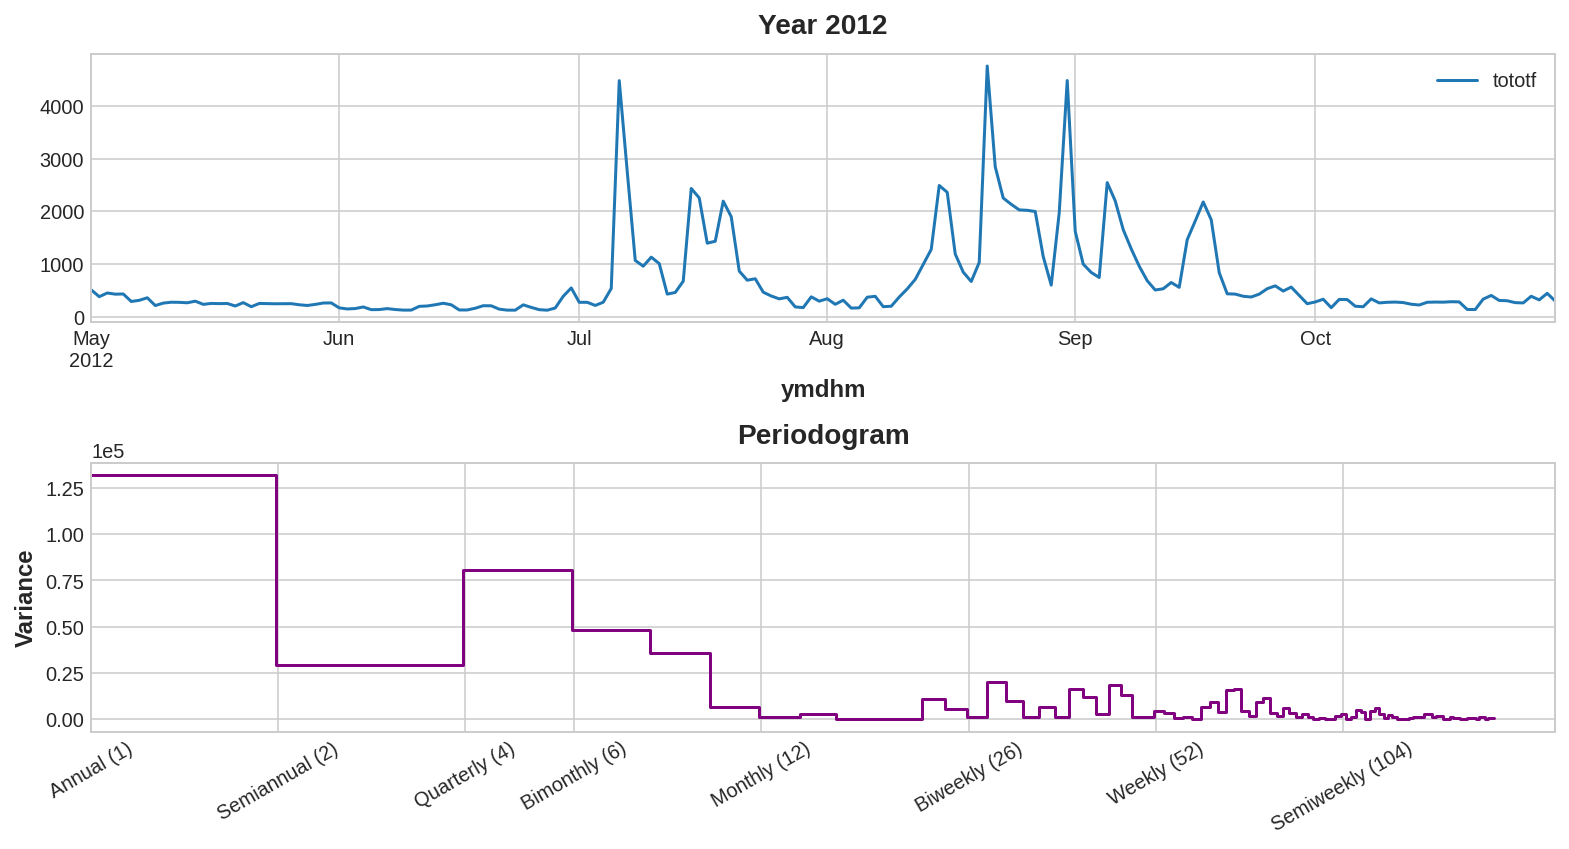

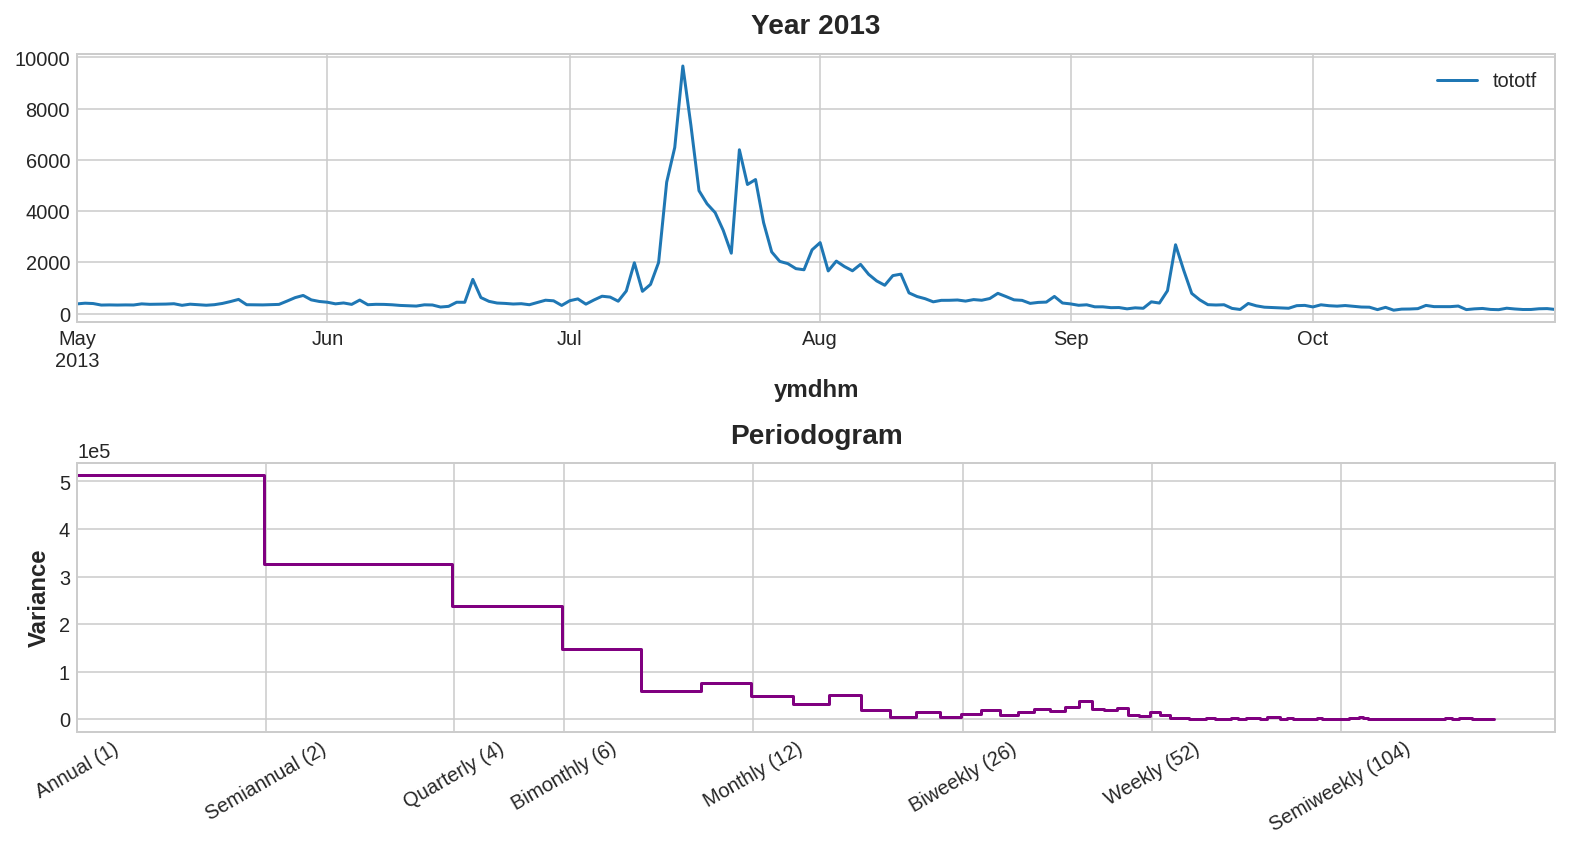

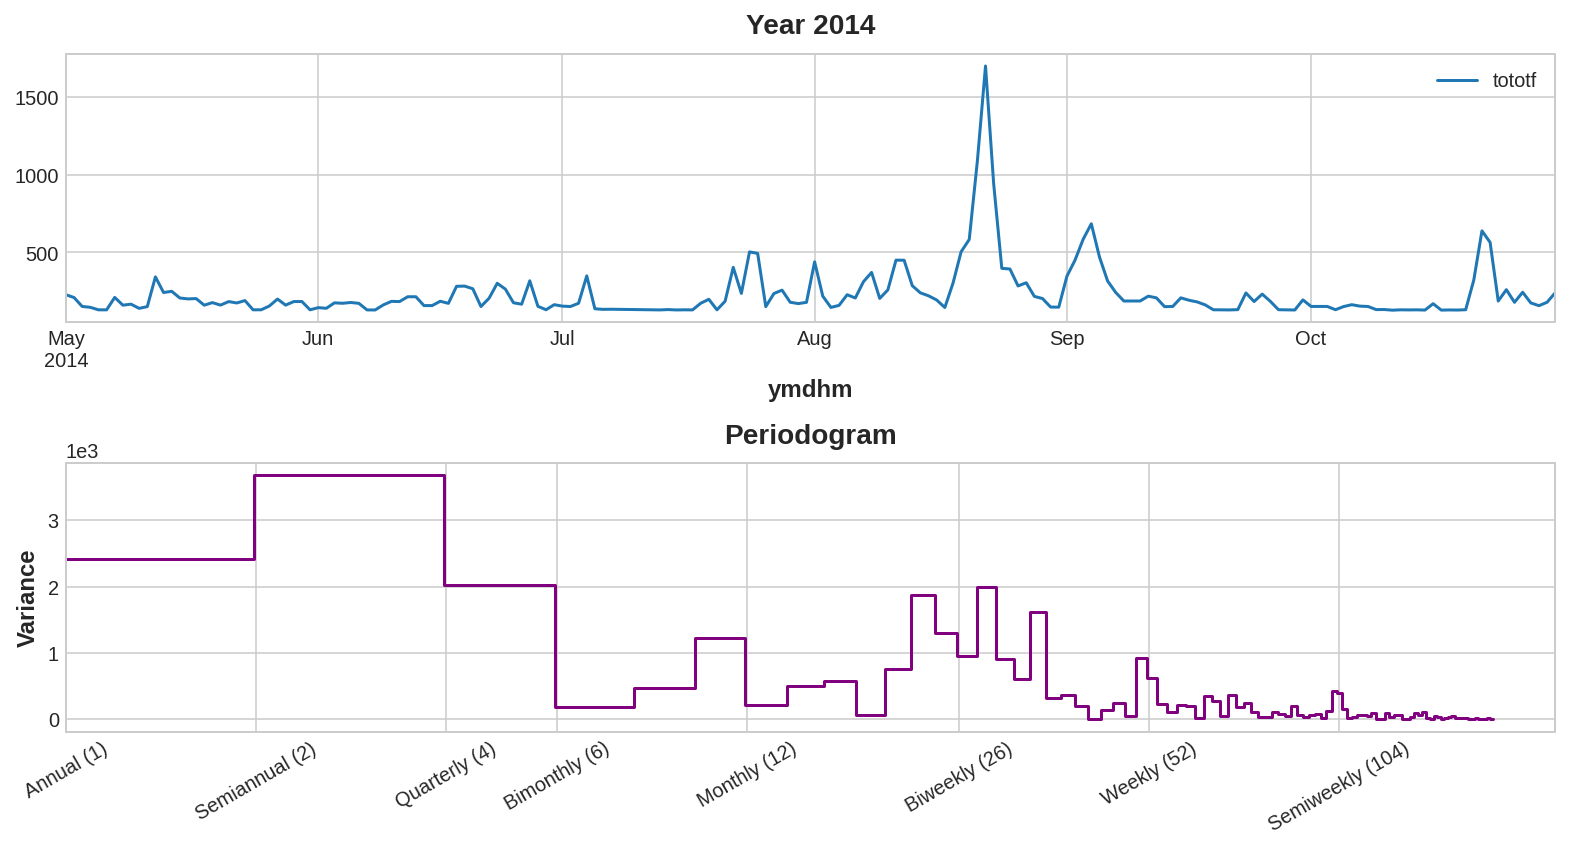

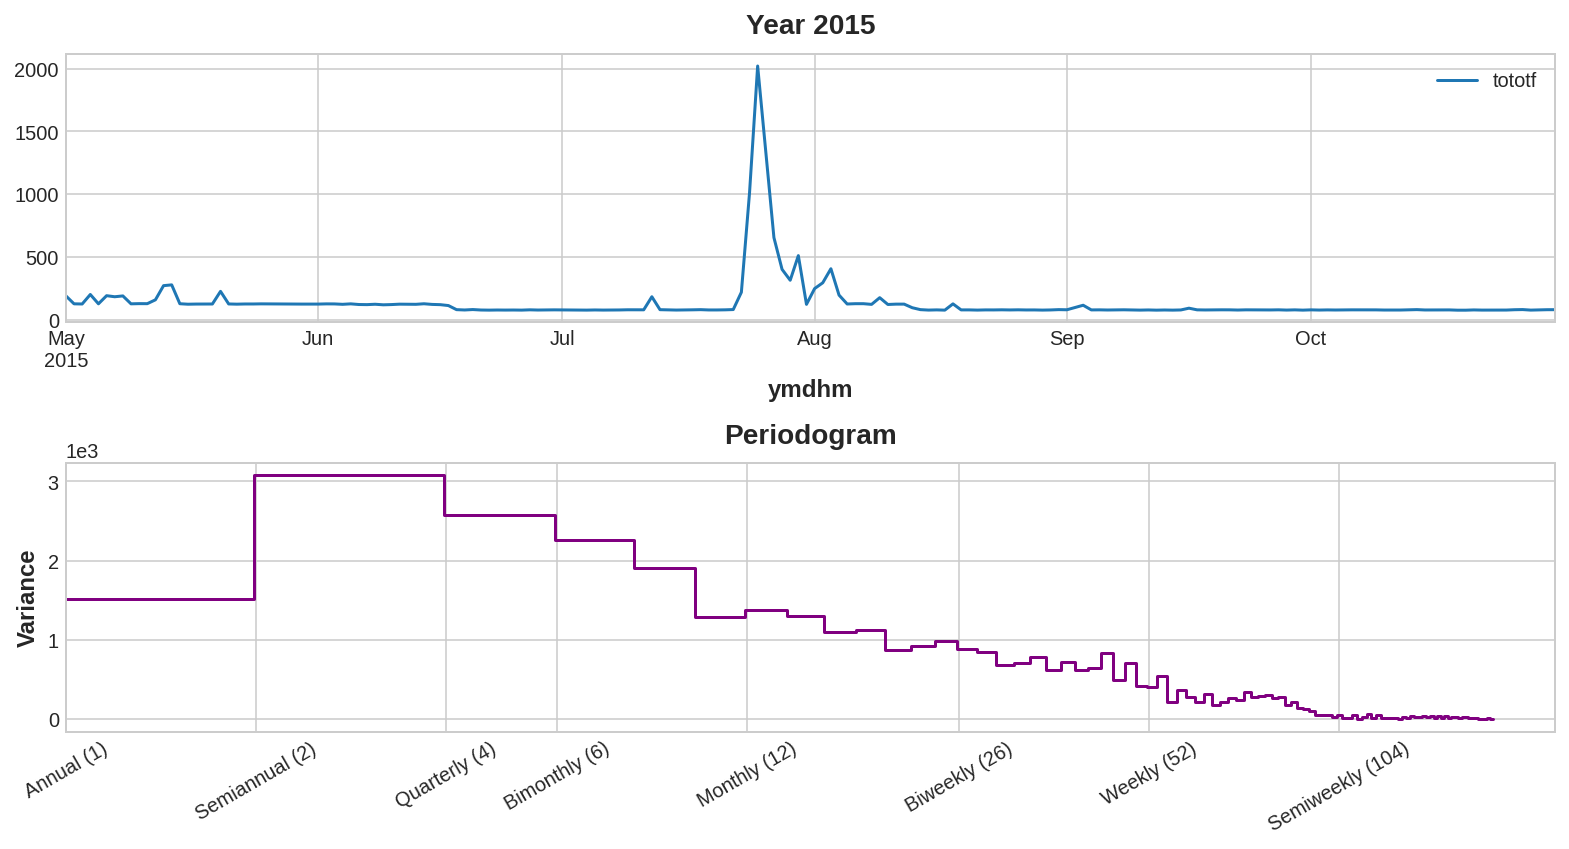

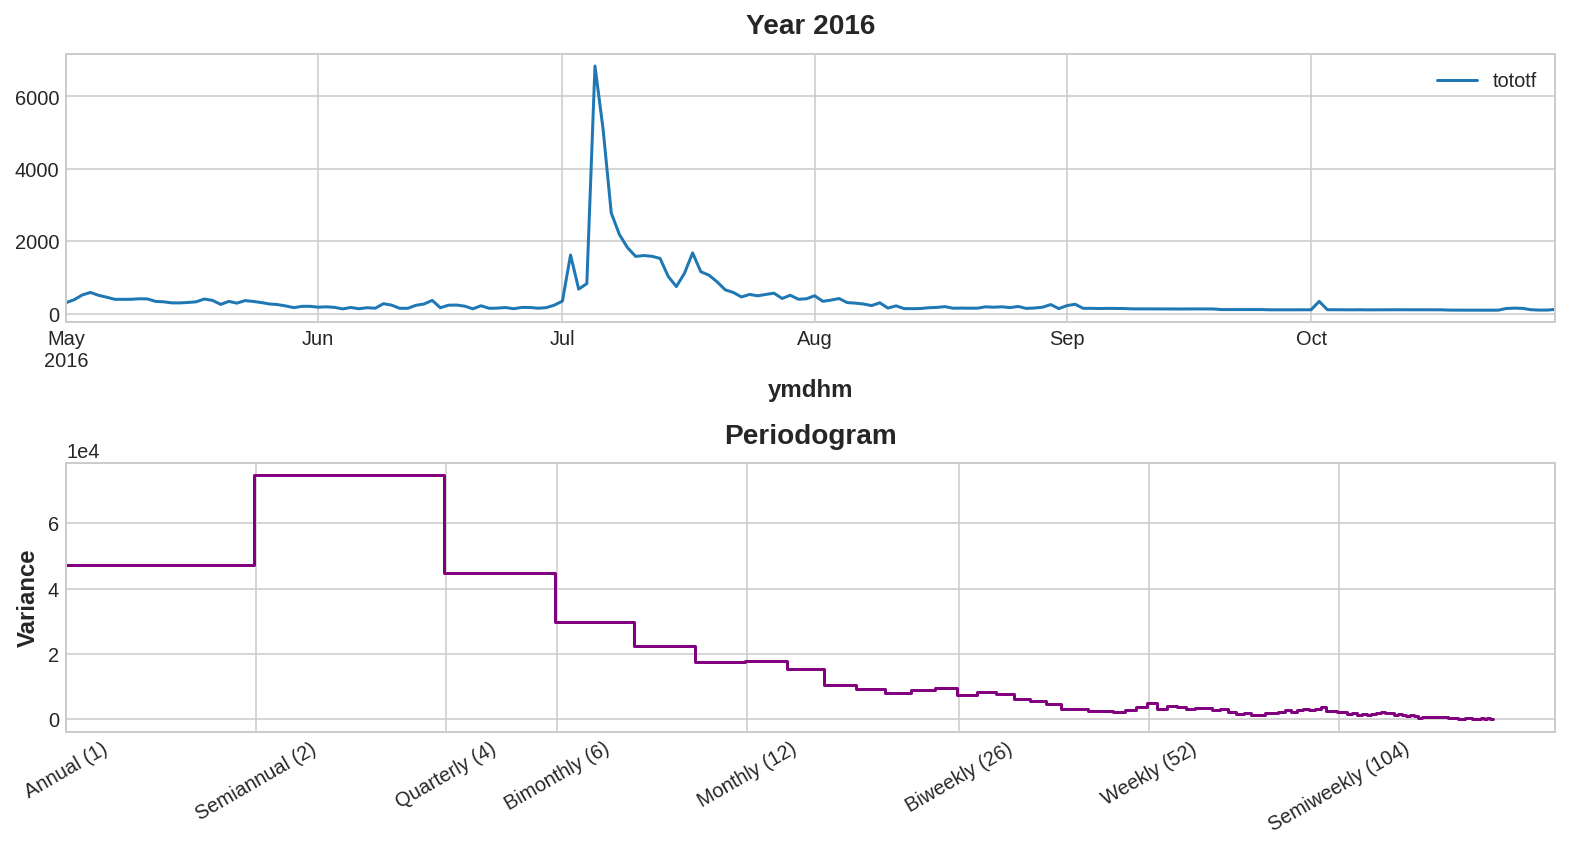

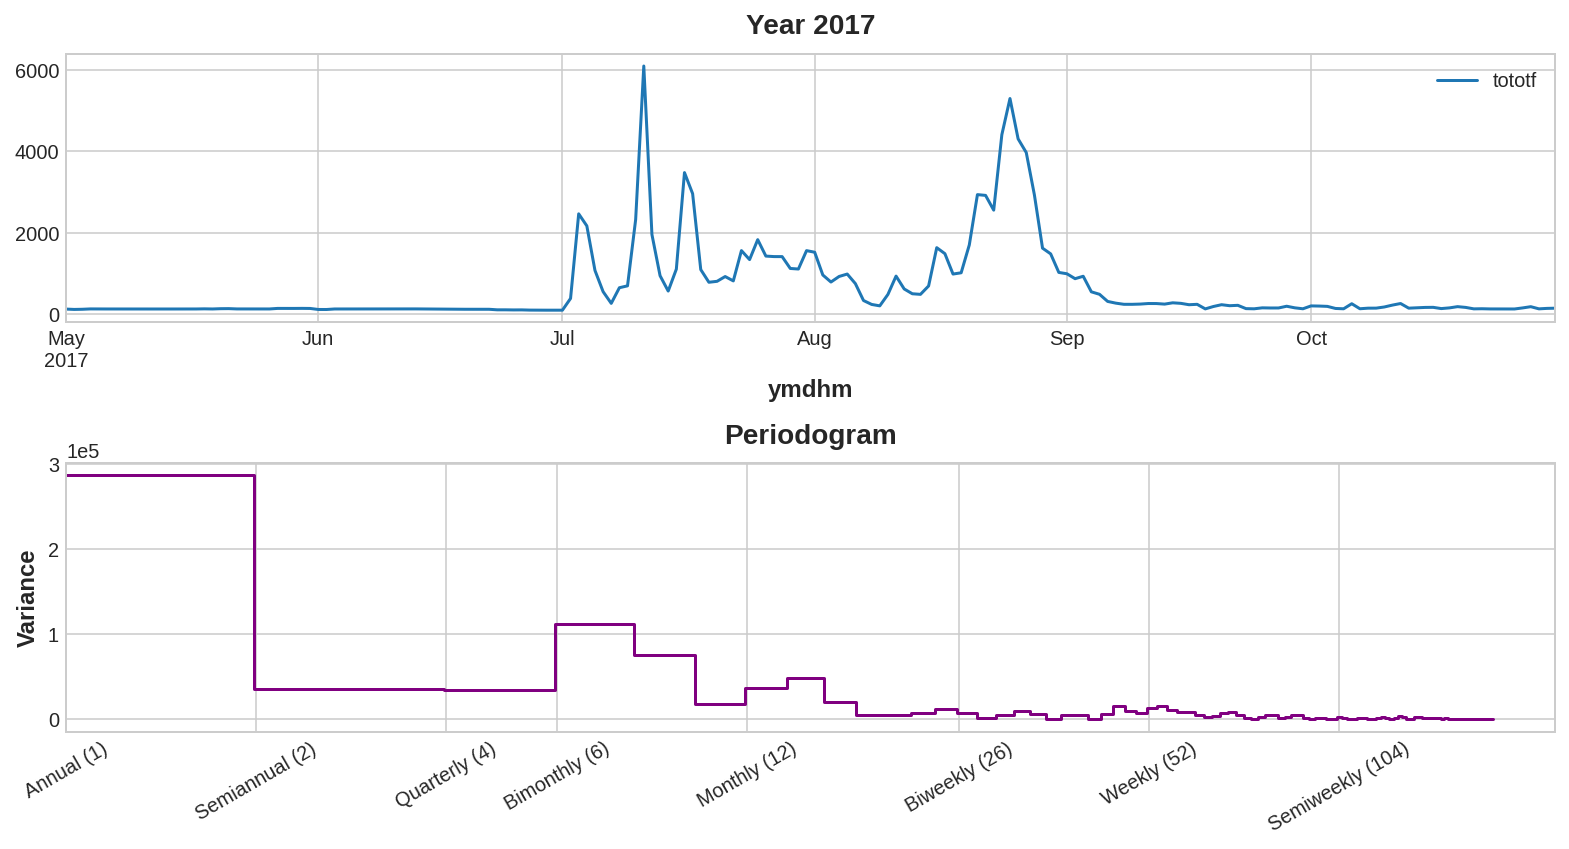

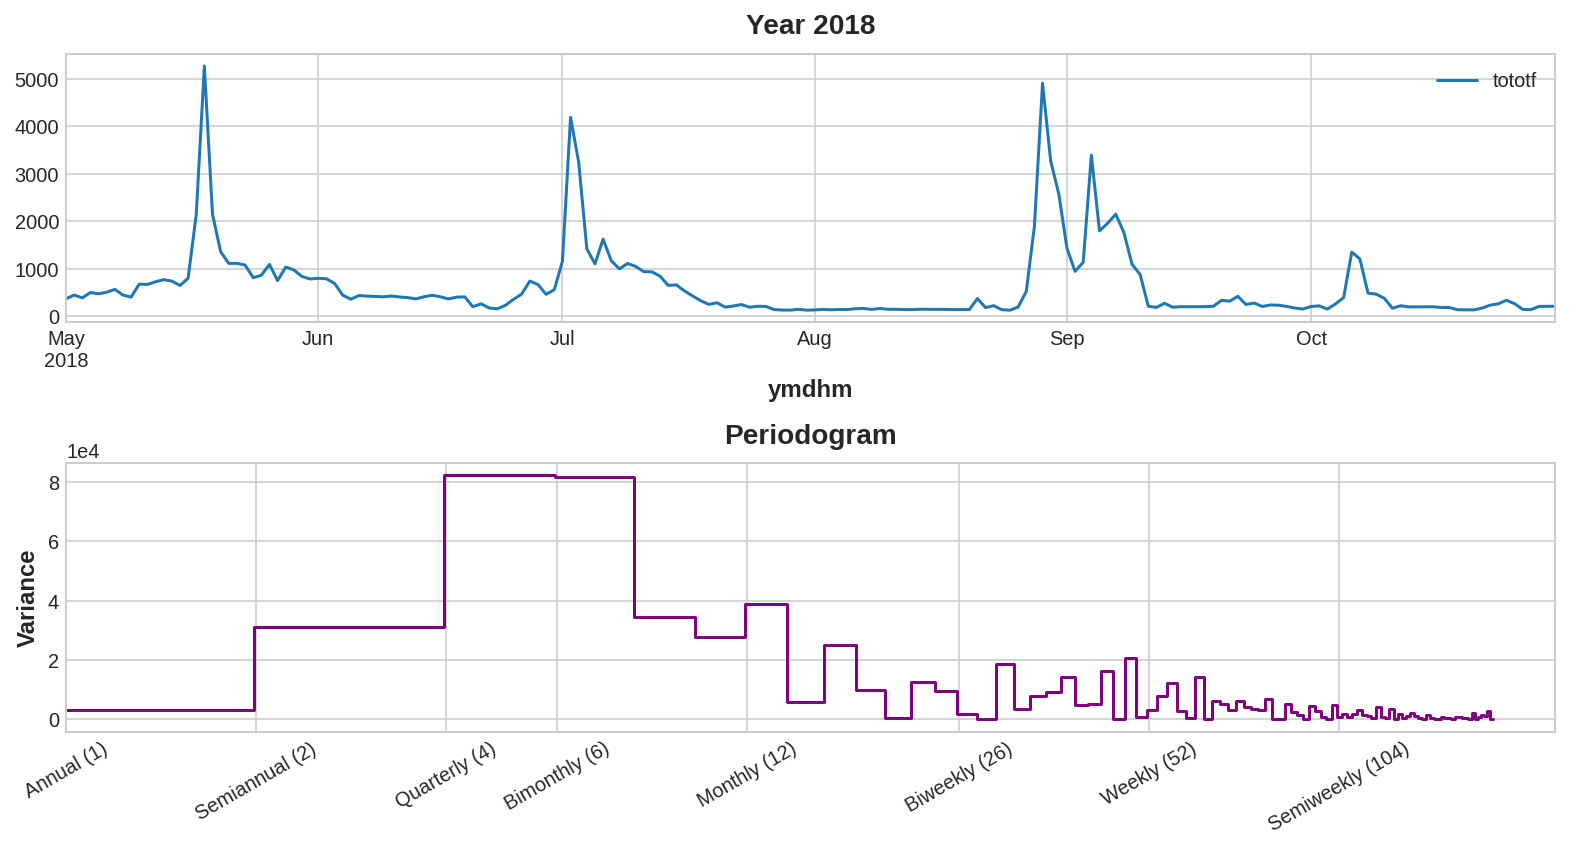

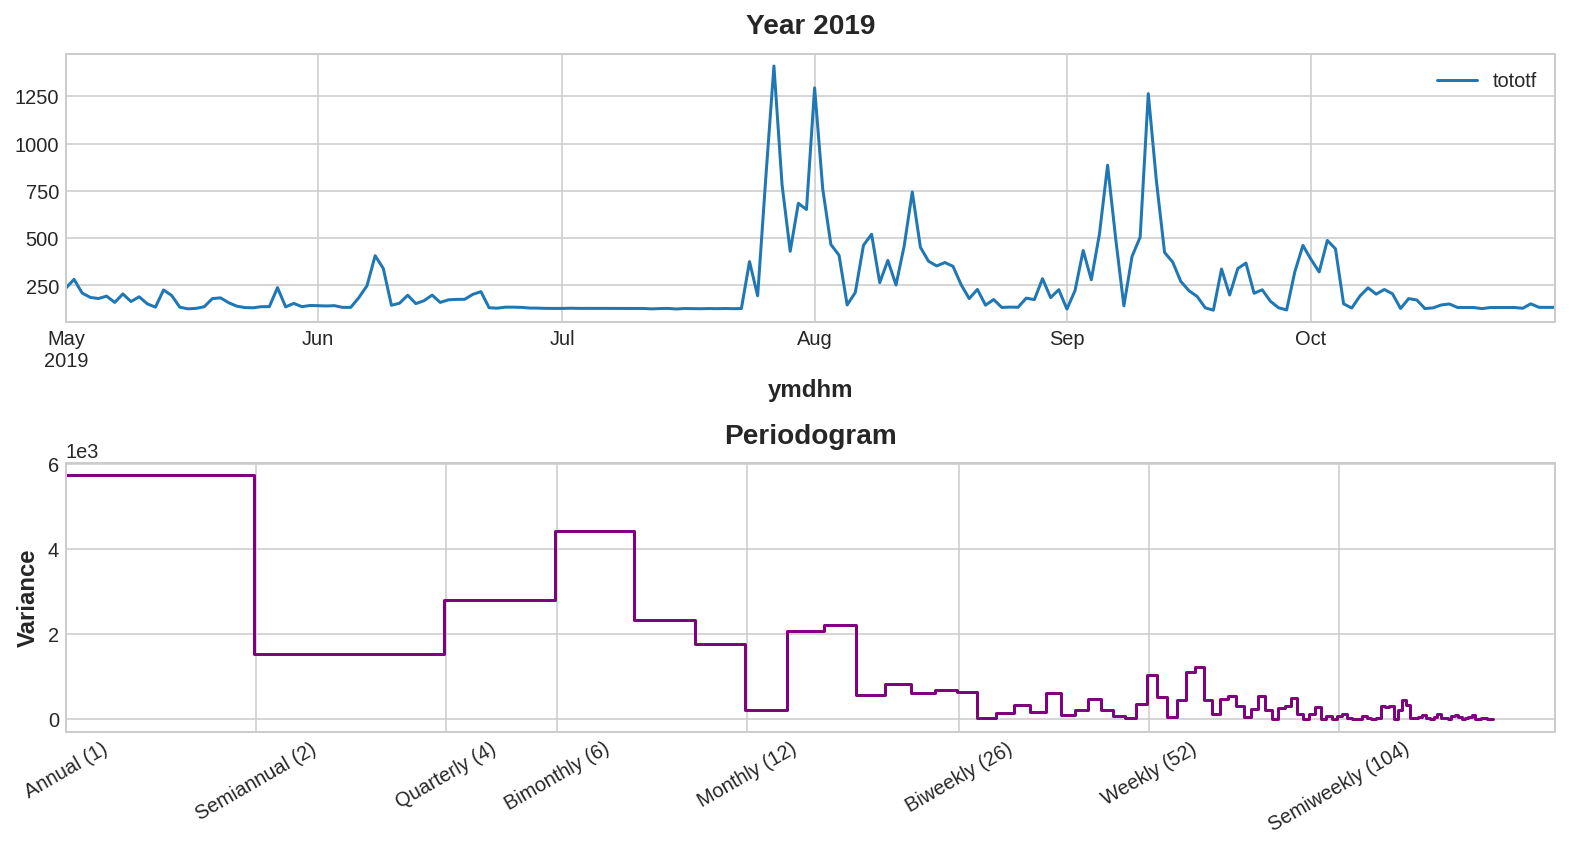

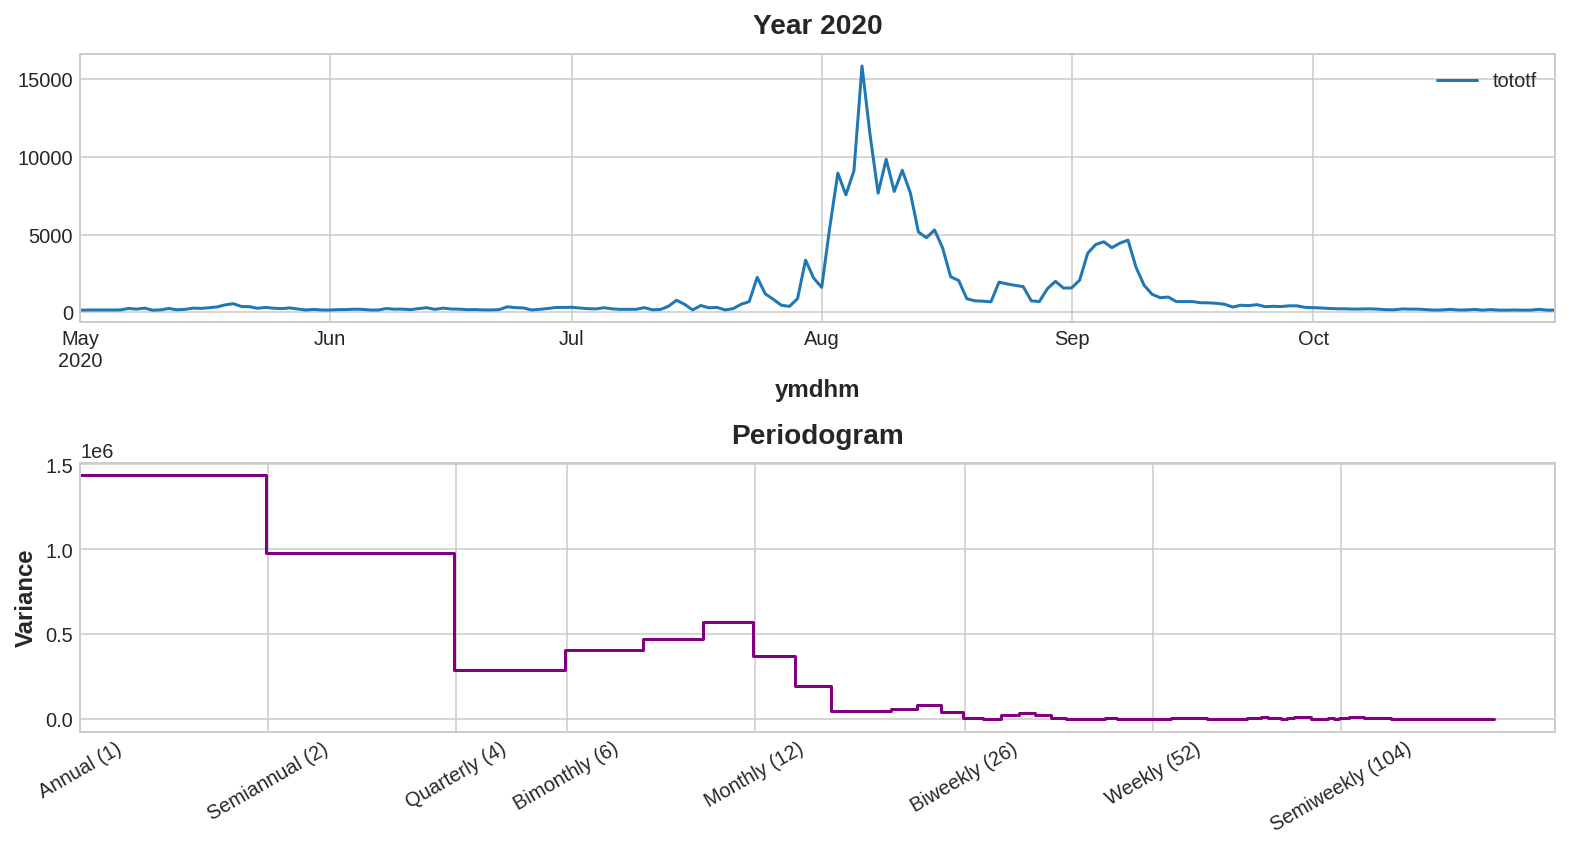

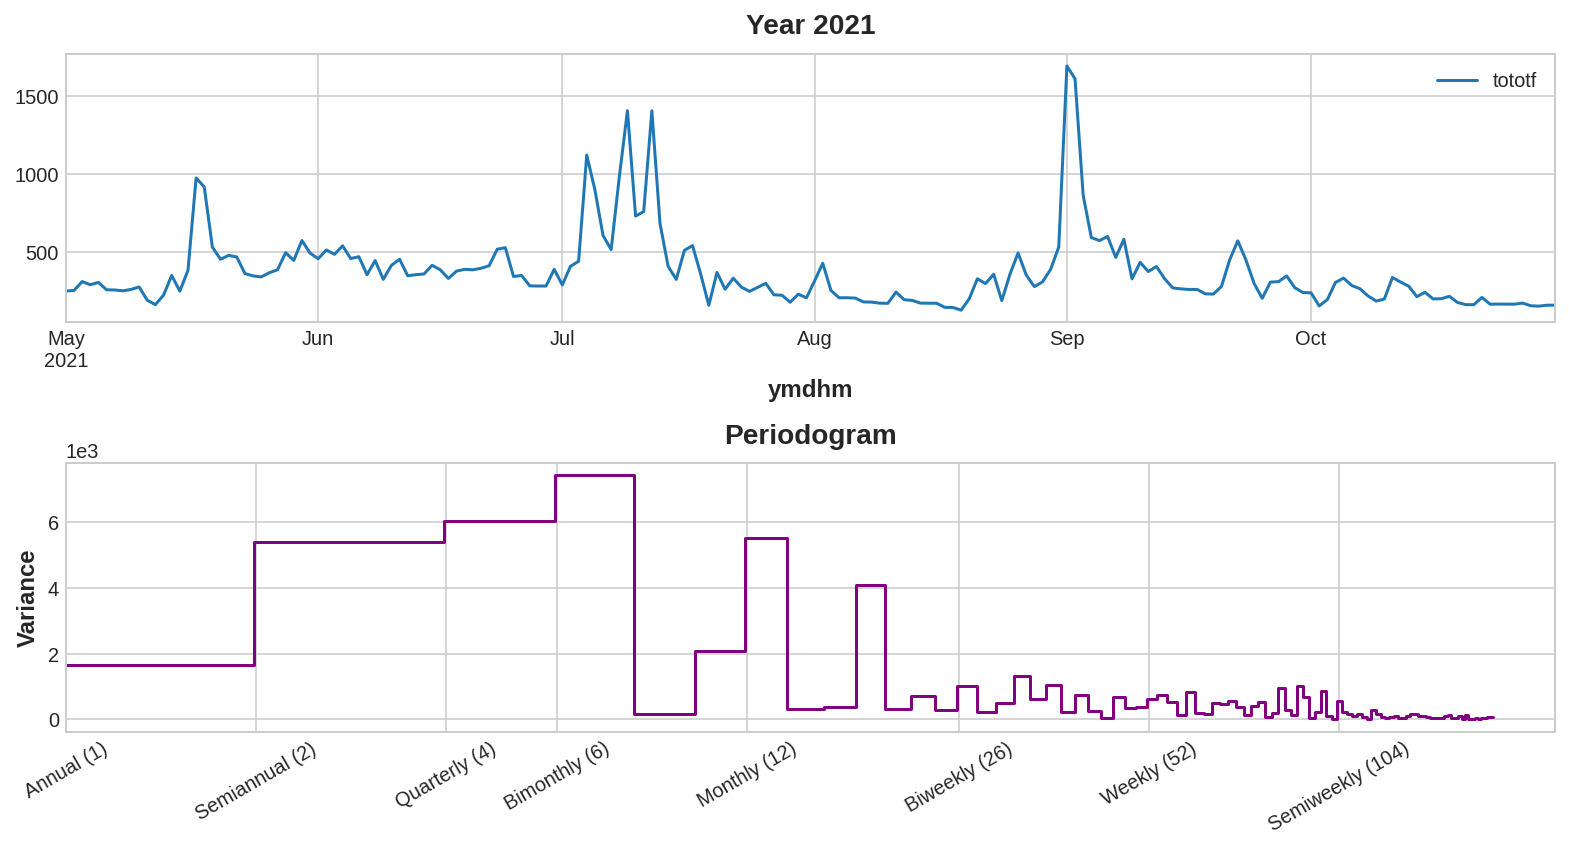

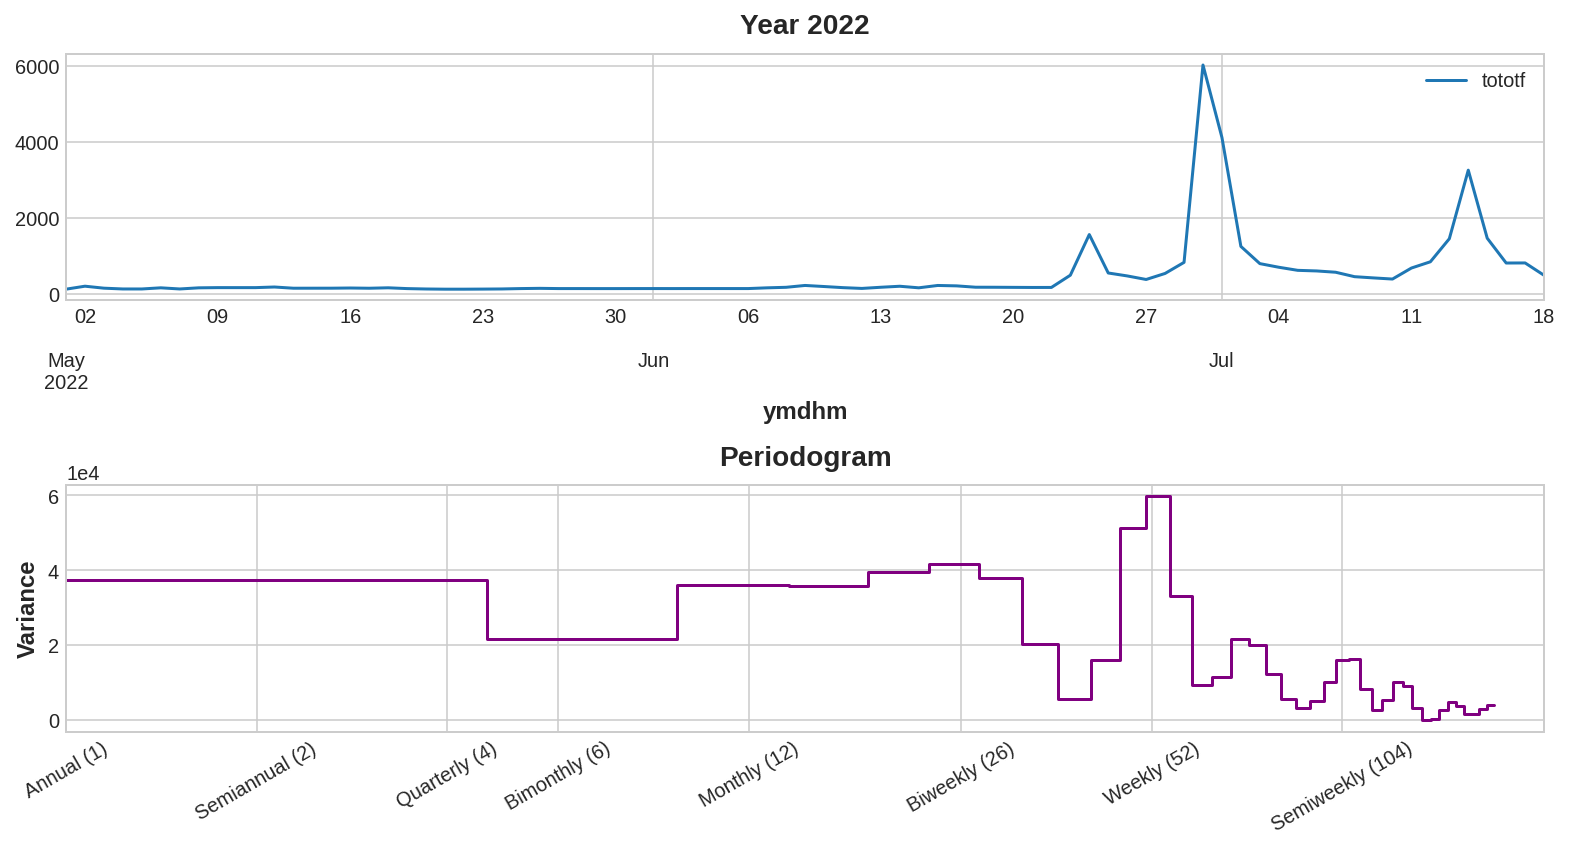

In [64]:
for i in range(0, 11):
    year = 2012 + i
    yearly_df = tot_df[tot_df.index.year == year].to_period("D")
    average_df = yearly_df.groupby('ymdhm').mean()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
    average_df.plot(ax=ax1)
    ax1.set_title(f'Year {year}')
    plot_periodogram(average_df.tototf, ax=ax2)

#### fourier feature

In [23]:
y = tot_df.copy()

fourier = CalendarFourier(freq="A", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=False,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [74]:
y.head()

tototf
ymdhm                      
2012-05-01 00:00:00   555.0
2012-05-01 00:10:00   562.9
2012-05-01 00:20:00   576.4
2012-05-01 00:30:00   563.1
2012-05-01 00:40:00   576.4

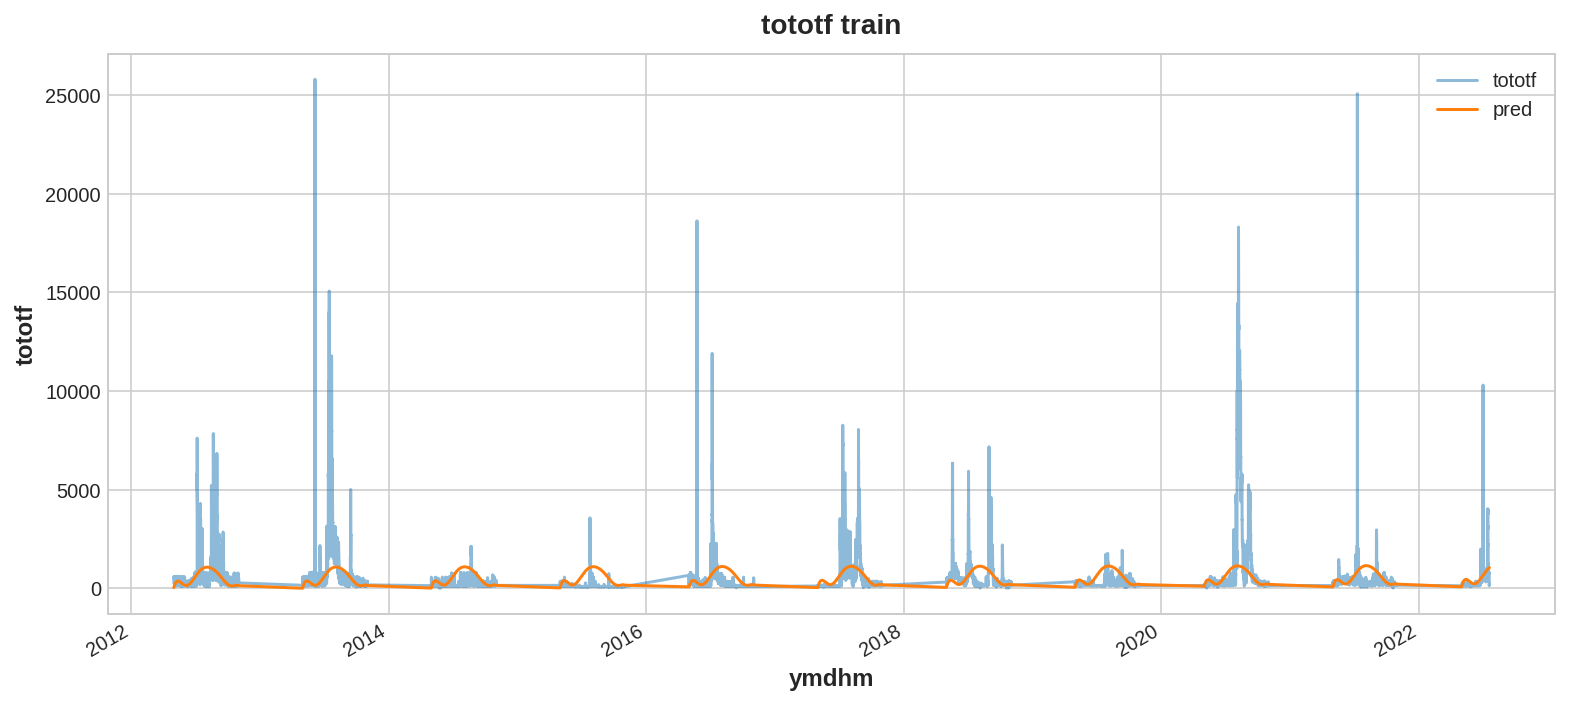

In [81]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

ax = y.plot(alpha=0.5, title="tototf train", ylabel="tototf")
ax = y_pred.plot(ax=ax, label='pred')
ax.legend()

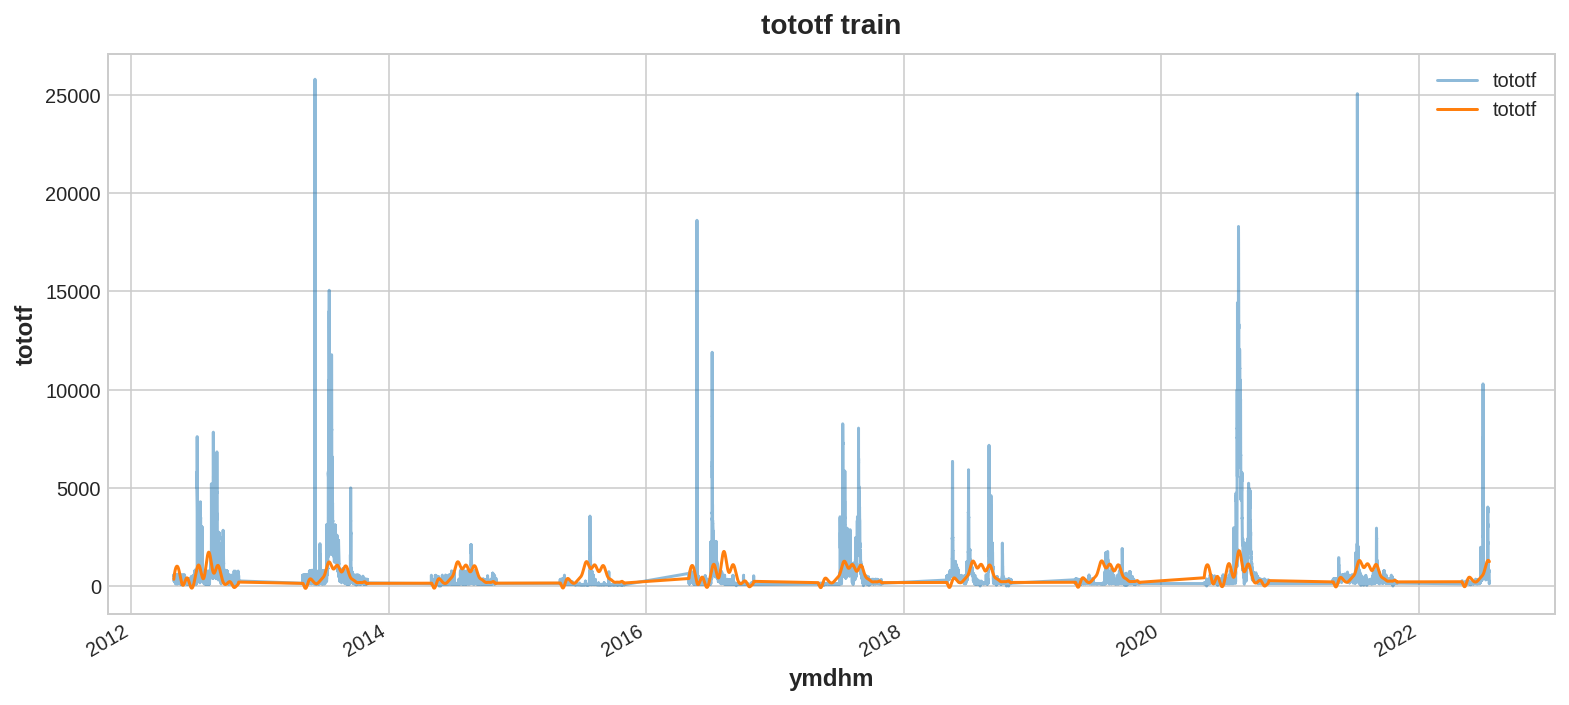

In [41]:
y = tot_df.copy()

annual_fourier = CalendarFourier(freq="A", order=10)
quarter_fourier = CalendarFourier(freq="Q", order=4)
monthly_fourier = CalendarFourier(freq="M", order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=False,
    additional_terms=[
        annual_fourier,
        quarter_fourier,
        # monthly_fourier
    ],
    drop=True,
)
X = dp.in_sample()

model = LinearRegression().fit(X, y)
y_pred = pd.DataFrame(model.predict(X).flatten(), index=X.index, columns=['tototf'])

ax = y.plot(alpha=0.5, title="tototf train", ylabel="tototf")
ax = y_pred.plot(ax=ax, label='pred')
ax.legend()

In [42]:
avg_y = y.to_period('D').groupby('ymdhm').mean()
avg_y_pred = y_pred.to_period('D').groupby('ymdhm').mean()
avg_deseason = avg_y - avg_y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """


Text(0.5, 1.0, 'Deseasonalized tototf')

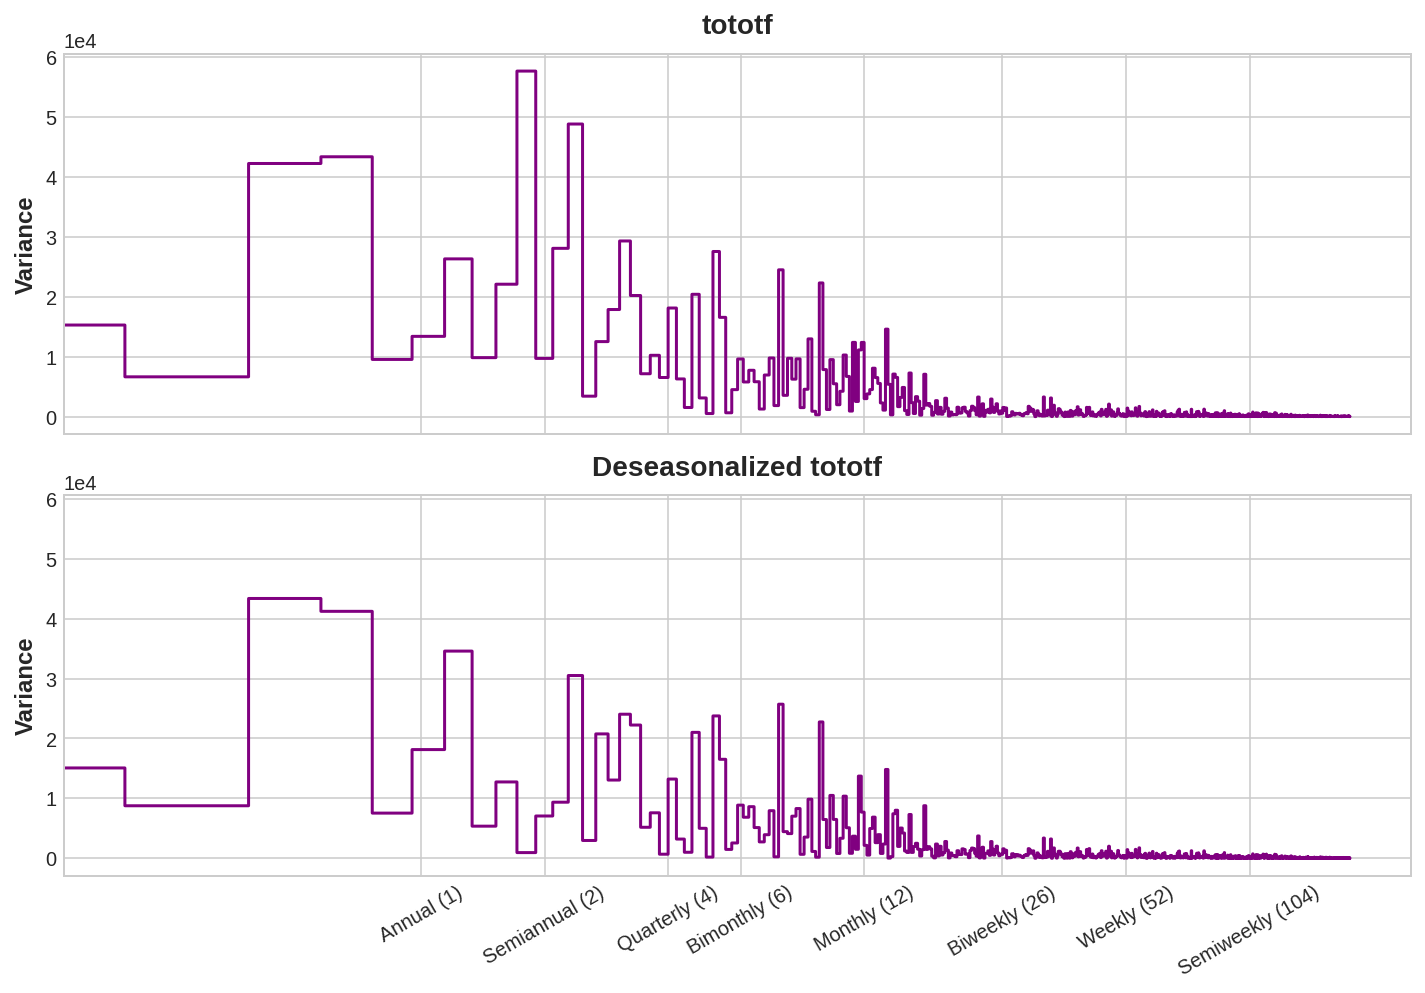

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(avg_y.tototf, ax=ax1)
ax1.set_title("tototf")
avg_deseason = avg_deseason.dropna()
ax2 = plot_periodogram(avg_deseason.tototf, ax=ax2)
ax2.set_title("Deseasonalized tototf")

In [44]:
X.head()

const  trend  sin(1,freq=A-DEC)  cos(1,freq=A-DEC)  \
ymdhm                                                                     
2012-05-01 00:00:00    1.0    1.0           0.874481          -0.485060   
2012-05-01 00:10:00    1.0    2.0           0.874423          -0.485164   
2012-05-01 00:20:00    1.0    3.0           0.874365          -0.485268   
2012-05-01 00:30:00    1.0    4.0           0.874307          -0.485373   
2012-05-01 00:40:00    1.0    5.0           0.874250          -0.485477   

                     sin(2,freq=A-DEC)  cos(2,freq=A-DEC)  sin(3,freq=A-DEC)  \
ymdhm                                                                          
2012-05-01 00:00:00          -0.848351          -0.529434          -0.051479   
2012-05-01 00:10:00          -0.848477          -0.529232          -0.051122   
2012-05-01 00:20:00          -0.848604          -0.529029          -0.050764   
2012-05-01 00:30:00          -0.848730          -0.528827          -0.050407   
2012-05-01 00:40:00          -0.848856          -0.528625          -0.050050   

                     cos(3,freq=A-DEC)  sin(4,freq=A-DEC)  cos(4,freq=A-DEC)  \
ymdhm                                                                          
2012-05-01 00:00:00           0.998674           0.898292          -0.439400   
2012-05-01 00:10:00           0.998692           0.898082          -0.439828   
2012-05-01 00:20:00           0.998711           0.897872          -0.440256   
2012-05-01 00:30:00           0.998729           0.897662          -0.440684   
2012-05-01 00:40:00           0.998747           0.897452          -0.441112   

                     ...  sin(10,freq=A-DEC)  cos(10,freq=A-DEC)  \
ymdhm                ...                                           
2012-05-01 00:00:00  ...            0.938710           -0.344707   
2012-05-01 00:10:00  ...            0.938299           -0.345826   
2012-05-01 00:20:00  ...            0.937886           -0.346945   
2012-05-01 00:30:00  ...            0.937471           -0.348062   
2012-05-01 00:40:00  ...            0.937056           -0.349180   

                     sin(1,freq=Q-DEC)  cos(1,freq=Q-DEC)  sin(2,freq=Q-DEC)  \
ymdhm                                                                          
2012-05-01 00:00:00           0.877303          -0.479937          -0.842101   
2012-05-01 00:10:00           0.877072          -0.480358          -0.842618   
2012-05-01 00:20:00           0.876842          -0.480779          -0.843134   
2012-05-01 00:30:00           0.876611          -0.481199          -0.843649   
2012-05-01 00:40:00           0.876381          -0.481619          -0.844163   

                     cos(2,freq=Q-DEC)  sin(3,freq=Q-DEC)  cos(3,freq=Q-DEC)  \
ymdhm                                                                          
2012-05-01 00:00:00          -0.539320          -0.068991           0.997617   
2012-05-01 00:10:00          -0.538512          -0.067556           0.997715   
2012-05-01 00:20:00          -0.537704          -0.066121           0.997812   
2012-05-01 00:30:00          -0.536895          -0.064685           0.997906   
2012-05-01 00:40:00          -0.536086          -0.063250           0.997998   

                     sin(4,freq=Q-DEC)  cos(4,freq=Q-DEC)  
ymdhm                                                      
2012-05-01 00:00:00           0.908324          -0.418268  
2012-05-01 00:10:00           0.907520          -0.420009  
2012-05-01 00:20:00           0.906713          -0.421749  
2012-05-01 00:30:00           0.905902          -0.423487  
2012-05-01 00:40:00           0.905088          -0.425224  

[5 rows x 30 columns]

## target column 

Text(0.5, 1.0, 'targets')

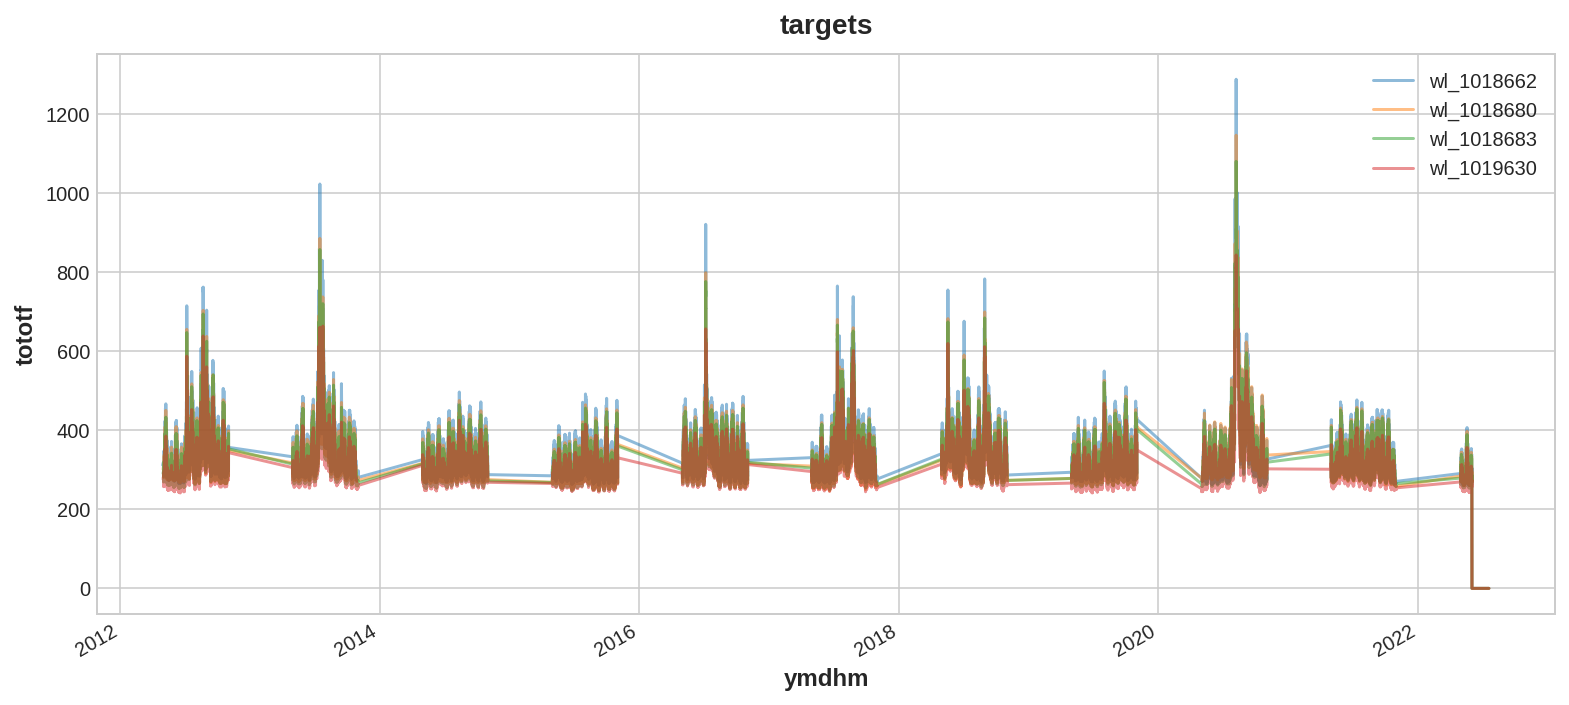

In [46]:
target_y = water_df.loc[:, target_cols]
ax = target_y.plot(alpha=0.5, title="tototf train", ylabel="tototf")
ax.set_title('targets')

In [47]:
target_y.columns

Index(['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'], dtype='object')

In [69]:
for col in target_y.columns:
    df = target_y[col].to_frame().dropna()
    df = df.join(X, how='left')
    y = df[col]
    train_X = df.drop([col], axis=1)
    model = LinearRegression().fit(train_X, y)
    y_pred = pd.DataFrame(model.predict(train_X).flatten(), index=train_X.index, columns=[col])

    ax = y.plot(alpha=0.5, title="original", ylabel="tototf")
    ax = y_pred.plot(ax=ax, label='pred')
    ax.legend()

ValueError: ignored